In [1]:
%env CUDA_VISIBLE_DEVICES= 1


env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'

## IndicTrans2

In [3]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)

2025-02-12 19:31:07.452481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 19:31:07.631917: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 19:31:08.335548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-12 19:31:08.335676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

cuda


In [4]:
# print(torch.cuda.get_device_name())

In [5]:
import transformers
print(transformers.__version__)

4.46.3


In [6]:
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)
import pandas as pd
pir= poss_indic_rel.possible_relations
pir

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings

In [7]:
# drop "child" item from ambiguos_words
index_child = ambiguos_words.index("child")
ambiguos_words.pop(index_child)


'child'

In [8]:
ambiguos_words

['grandmother',
 'grandfather',
 'uncle',
 'aunt',
 'brother-in-law',
 'sister-in-law',
 'cousin',
 'nephew',
 'niece']

In [9]:
# span_encodings['ory_Orya']

In [10]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model

In [11]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir,  quantization)

ip_en_ind = IndicProcessor(inference=True)

# Util Functions

In [12]:
def resolve_logits_for_best_beam(outputs, num_beams):
    """ Resolve the logits from the best beam, using model output from a generate call.
        For a shape [tokens?, batch_size*num_beams, vocab], returns [tokens?, batch_size, vocab]

        Assumes num_return_sequences=1."""

    # print("length of output beam", len(outputs.beam_indices))
    # print("shape of beam_indices", outputs.beam_indices.shape)
    # print("shape of logits", (outputs.logits[0].shape))
    # print("length of logits", len(outputs.logits))
    # print("length od outputs", len(outputs))
    best_logits  = []
    beam_indices = [outputs.beam_indices[:, i].tolist() for i in range(len(outputs.logits)) if i < outputs.beam_indices.shape[1]]  
    # print("length of beam_indices", len(beam_indices))

    for beam_index, logits in zip(beam_indices, outputs.logits):
        beam_index = [ idx if idx != -1 else ((num_beams*(i+1))-1) for i, idx in enumerate(beam_index) ]
        best_logits.append(logits[beam_index,:])

    return best_logits




def get_logits_for_span(logits, translations, tokenizer, search_spans, span_encodings, lang):
    """ Given search spans, returns the logits before the span was generated.

    Args:
        logits (tuple[Tensor]): Tuple of tensors, of shape [tokens?, batch_size, vocab]
        sequences (tuple[list[int]]): Tokenized output sequences.
        tokenizer (PreTrainedTokenizerBase): Tokenizer for the model.
        search_spans (list[str]): batch_size spans to search for. Must be present in the generated sequences.

    Returns:
        Tensor: Tensor of shape [batch_size, vocab] indicating the logits before the span for each batch element.
    """
    if isinstance(search_spans, str):
        search_spans = [ search_spans ] * len(translations)

    # with tokenizer.as_target_tokenizer():   
    #     detok_outputs = tokenizer.batch_decode(translations, skip_special_tokens=True)

    # positions = [ output.index(span) for output, span in zip(translations, search_spans) ]
    logit_pos = [  ]

    for seq,  span  in zip(translations,  search_spans): 
        # print("Span to search for:", span, span_encodings[lang])
        key = next((k for k in span_encodings[lang].keys() if span in k), "None")
        if key == "None" and (lang == 'hin_Deva' or lang == 'ory_Orya'):
            print("Span not found in span_encodings for language", lang, "span:", span, "seq:", seq) 
        subtokens = span_encodings[lang][key]
        # print("subtokens", subtokens)
        # print("for span:", span, "subtokens", subtokens)
        # print("seq", seq)
        idx = 0
        while idx < len(seq)-1:
            if any( idx+i < len(seq) and seq[idx+i] == tok for i, tok in enumerate(subtokens)): 
                # print( "found", idx)
                break
            idx += 1
        logit_pos.append(idx-1)
    
    # print("logit_pos", logit_pos)
    # print("Dimensions of logits", logits[0].shape, len(logits))

    selected_logits = []
    # Iterate over each batch and corresponding token position
    for batch, token in enumerate(logit_pos):
        # print("batch, token", batch, token)
        # print("len(logits)", len(logits))
        # print("Shape of logits", logits[0].shape)
        # # print("logits token", logits[token])
        # print("logits 1st item 1st row",logits[0][0])
        # Extract logits for the specific token position in the current batch
        current_logit = logits[token][batch, :]
        # current_logit = logits[token][0]
        
        # Append the selected logit to the list
        selected_logits.append(current_logit)

    # Stack the list of selected logits into a tensor
    selected_logits = torch.stack(selected_logits)

    return selected_logits
        
    # return selected_logits
    # return torch.stack([ logits[token][batch,:] for batch, token in enumerate(logit_pos) ])


In [13]:
def get_search_spans(inp_sents, tgt_lang, translations):
    search_spans= []
    root_amb_words=[]
    # print("inp_sents", inp_sents)
    for idx, inp in enumerate(inp_sents):
        # check which word from ambiguos_Wwords in present in the input sentence
        curr_amb_word= None
        for word in ambiguos_words:
            if word in inp:
                curr_amb_word= word
        root_amb_words.append(curr_amb_word)

        # get the possible relations for the current ambiguous word
        possible_relations= pir[curr_amb_word][tgt_lang].keys()
        # print("Possible relations for the word", curr_amb_word, "in", tgt_lang, "are", possible_relations)

        # find the word in the translation from the possible relations. if not found print the translation
        for rel in possible_relations:
            if rel in translations[idx]:
                # print("Relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx], "at ", translations[idx].index(rel), "\nso sentece is", translations[idx][translations[idx].index(rel):])
                search_spans.append(rel)
                break
        else:
            # print("No relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx])
            search_spans.append(translations[idx][   translations[idx].index(" ")+1   ]) # 2nd word in the translation
    # print("Search spans are", search_spans)
    return root_amb_words, search_spans
       



In [14]:



def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, span_encodings):
    translations = []
    start_logits = []
    root_amb_words = []
    searched_spans = []
    for i in tqdm(range(0, len(input_sentences), BATCH_SIZE)):
        batch = input_sentences[i : i + BATCH_SIZE]
        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)
        with torch.no_grad():
            # generated_tokens = model.generate(
            outputs = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1, # TODO temp
                output_scores=True,
                output_logits=True,
                return_dict_in_generate=True,

            )
            # print("Length of outputs.logits actual", len(outputs.logits))
            # print("Shape of outputs.logits actual", outputs.logits[0].shape)

            # print("Length of outputs.beam_indices actual", len(outputs.beam_indices))
            # print("Shape of outputs.beam_indices actual", outputs.beam_indices.shape)
            # print("*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?**********", outputs.beam_indices.shape[1] == len(outputs.logits))
            
            outputs.beam_indices = outputs.beam_indices.cpu()
            outputs.logits = tuple(logits.cpu() for logits in outputs.logits)               
        # Decode the generated tokens into text
        generated_tokens = outputs.sequences
        # print("len generated_tokens: ", (generated_tokens[0]).shape)
        # print("1st generated token: ", generated_tokens[0])
        vector = generated_tokens.detach().cpu().tolist()
        # print("length of outputs vectors: ", len(vector), len(vector[0]))
        # print("vector of generated_tokens: ", vector)
        # print("1st vector: ", vector[0])



        with tokenizer.as_target_tokenizer():
            decoded_op = tokenizer.batch_decode(
                vector,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # print("1st decoded_op: ", decoded_op[0])
        # Postprocess the translations, including entity replacement
        transl = ip.postprocess_batch(decoded_op, lang=tgt_lang)

        # print("translations: ", transl)
        

        root_words, search_spans = get_search_spans(batch,  tgt_lang, transl)
        searched_spans += search_spans
        root_amb_words += root_words
        # print("length search_spans: ", len(search_spans))
        best_logits = resolve_logits_for_best_beam(outputs, num_beams=5)
        # print("length best_logits: ",len(best_logits))
        # print("length of best_logits: ", len(best_logits), (best_logits[0]).shape)

        start_logits += get_logits_for_span(best_logits, outputs.sequences, tokenizer, search_spans, span_encodings, tgt_lang)
        # start_logits += get_logits_for_span(best_logits, translations, tokenizer, search_spans)
        translations += transl
        del inputs
        torch.cuda.empty_cache()

    return translations, start_logits, root_amb_words, searched_spans

In [15]:
lang_script_list = [
    'hin_Deva', 
    'guj_Gujr',
    'mar_Deva', 
    'ory_Orya',
     'ben_Beng', 
    'tam_Taml', 
    'pan_Guru',
     'tel_Telu',
      'mal_Mlym', 'kan_Knda', 
                           ]

In [16]:
lang_code_map = {
    'eng_Latn': 'Eng',
    'hin_Deva': 'Hin',
    'guj_Gujr': 'Guj',
    'kan_Knda': 'Kan',
    'mal_Mlym': 'Mal',
    'mar_Deva': 'Mar',
    'tam_Taml': 'Tam',
    'tel_Telu': 'Tel',
    'pan_Guru': 'Pun',
    'ben_Beng': 'Ben',
    'ory_Orya': 'Odi'
}


In [17]:
sents = []
with open('../test_sentences_eng.txt', 'r') as f:
    sents = f.readlines()
sents = [sent.strip() for sent in sents if sent.find('child')==-1]
print(len(sents))

1809


In [18]:
# append the generated sentences to the list sents
with open('../generated_sentences_relations.txt', 'r') as f:
    sents += f.readlines()

# print("sents", sents)
print("length of sents", len(sents))

length of sents 10741


In [19]:
SAMPLE_SIZE = len(sents)


# pick up random samples
# SAMPLE_SIZE = 60
# import random
# random.seed(42)
# sents = random.sample(sents, SAMPLE_SIZE)

# sents
SAMPLE_SIZE

10741

In [20]:
# for each sentence, check if it has any of the ambiguos words. If no then remove it from sents
sents = [sent for sent in sents if any( word in sent for word in ambiguos_words)]
len(sents)

10557

# Execute Translations

In [21]:
src_lang = "eng_Latn"
output_trnsl={}
output_logits={}
output_search_spans={}

for lang in lang_script_list:
    tgt_lang = lang
    print(lang)
    # if tgt_lang != 'ory_Orya':
    #     continue
    translations, logits, root_amb_words, searched_spans = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind, span_encodings)
    output_trnsl[lang] = translations
    output_logits[lang] = logits
    output_search_spans[lang] = searched_spans

    ## save the logits with vocab words to a file
    # with open('test_translations/indic_trans2/logits_exp/test_transl_it2_'+lang+str(SAMPLE_SIZE)+'_logits.txt', 'w') as f:
    #     for logit in logits:
    #         f.write(root_word+"--"+ lang_word+"::"+str(logit) + '\n')



    # # save hindi translations to a file test_translations_hin.txt
    with open('../test_translations/indic_trans2/logits_exp/test_transl_it2_'+lang+str(SAMPLE_SIZE)+'.txt', 'w') as f:
        for sent in translations:
            f.write(sent + '\n')

    # save the logits to a file 
    # with open('test_trasnlations/indic_trans2/test_transl_it2_'+lang+'_logits.txt', 'w') as f:
    #     for logit in logits:
    #         f.write(str(logit) + '\n')

hin_Deva


  0%|                                                                                                                                                                                                                                                | 0/2640 [00:00<?, ?it/s]

/home/sofia/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
 11%|████████████████████████▎                                                                                                                                                                                                             | 279/2640 [01:56<19:22,  2.03it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,    44,  4459, 14465,    90,
          107,     6,     2,     1,     1], device='cuda:0')


 18%|████████████████████████████████████████▍                                                                                                                                                                                             | 464/2640 [03:31<24:33,  1.48it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,     9,   103,  1658, 19611,  1361,
            8,     6,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1], device='cuda:0')


 18%|████████████████████████████████████████▌                                                                                                                                                                                             | 465/2640 [03:32<25:08,  1.44it/s]

Span not found in span_encodings for language hin_Deva span: य seq: tensor([    2,   445,  2062,     8,    29,   790, 39136,  1386,    26,   445,
        17023,    10, 29153,   851,   574,  9158,  1356,   107,     6,     2],
       device='cuda:0')


 19%|████████████████████████████████████████████▎                                                                                                                                                                                         | 508/2640 [03:55<20:45,  1.71it/s]

Span not found in span_encodings for language hin_Deva span: ध seq: tensor([    2, 27135,  1607,    10,   790, 39136,  1386,    31,  1046,  2362,
            8,     6,     2,     1,     1,     1,     1], device='cuda:0')


 20%|██████████████████████████████████████████████                                                                                                                                                                                        | 528/2640 [04:05<17:54,  1.96it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    12,  3647, 19129,    10,  2366,
            6,     2,     1,     1,     1,     1,     1], device='cuda:0')


 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                    | 565/2640 [04:28<24:49,  1.39it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  1843,  3836,    12, 12180,
        12793,    20,  4198,  2794,     8,     6,     2,     1,     1,     1],
       device='cuda:0')


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                                    | 570/2640 [04:32<24:36,  1.40it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  1843,  3836,    12, 12180,
        12793,    20,  4198,  2794,     8,     6,     2,     1],
       device='cuda:0')


 22%|██████████████████████████████████████████████████                                                                                                                                                                                    | 574/2640 [04:35<24:46,  1.39it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  1843,  3836,    12, 12180,
        12793,    20,  4198,  2794,     8,     6,     2,     1,     1,     1],
       device='cuda:0')


 22%|██████████████████████████████████████████████████▍                                                                                                                                                                                   | 579/2640 [04:38<23:46,  1.44it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  1843,  3836,    12, 12180,
        12793,    20,  4198,  2794,     8,     6,     2,     1],
       device='cuda:0')


 23%|████████████████████████████████████████████████████▍                                                                                                                                                                                 | 602/2640 [04:50<16:38,  2.04it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    12,   737,   458,    25,  7029,
            8,     6,     2,     1], device='cuda:0')


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 743/2640 [06:16<20:45,  1.52it/s]

Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,   792,  3205,     9,   428,    10,   790, 39136,  1386,    17,
          790,   746, 53994,   262,     6,     2,     1,     1],
       device='cuda:0')


 28%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 752/2640 [06:22<19:10,  1.64it/s]

Span not found in span_encodings for language hin_Deva span: ट seq: tensor([    2,  1658, 12537,     9,   428,    10,   790, 39136,  1386,    17,
          790,   746, 53994,   262,     6,     2,     1,     1,     1],
       device='cuda:0')


 29%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 761/2640 [06:27<19:10,  1.63it/s]

Span not found in span_encodings for language hin_Deva span: ट seq: tensor([    2,  1658, 12537,     9,   428,    10,   790, 39136,  1386,    17,
          790,   746, 53994,   262,     6,     2,     1,     1,     1],
       device='cuda:0')


 29%|███████████████████████████████████████████████████████████████████                                                                                                                                                                   | 770/2640 [06:33<18:47,  1.66it/s]

Span not found in span_encodings for language hin_Deva span: ट seq: tensor([    2,  1658, 12537,     9,   428,    10,   790, 39136,  1386,    17,
          790,   746, 53994,   262,     6,     2,     1,     1,     1],
       device='cuda:0')


 31%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 818/2640 [07:06<20:49,  1.46it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   504,  8514,  6015,   683,    87,     9,   428,    10,   790,
        39136,  1386,    12, 36207,  7808,  2198, 29461,    33,     6,     2],
       device='cuda:0')


 31%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 820/2640 [07:07<19:58,  1.52it/s]

Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2,   137,   504, 39136,  1386,     9,   683,    87,     9,   428,
           10,    17, 16862,  4140, 16414,     6,     2,     1,     1],
       device='cuda:0')


 32%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 841/2640 [07:21<20:47,  1.44it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   103,   887,   252, 19777,
         4441,  2153,   651,    10,   608,   540,   549,     6,     2],
       device='cuda:0')


 32%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 843/2640 [07:22<21:10,  1.41it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9, 15318,  2153, 23197,    55,
            9,   428,    10, 21200,     9,    44,    17,  8221,    36,    45,
          459,     6,     2], device='cuda:0')


 36%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 939/2640 [08:27<16:30,  1.72it/s]

Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2,   445,  3292,     8,    29,   504, 39136,  1386,    23, 20713,
         8819,  6685,     6,     2,     1,     1,     1], device='cuda:0')


 36%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 960/2640 [08:40<17:24,  1.61it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    12,  5416,  9304,    10, 40939,
           67, 10749,     8,     6,     2,     1], device='cuda:0')


 37%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 966/2640 [08:43<17:50,  1.56it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,   219, 49615,  5144, 28945,     9,   103,  3228,
            9, 15933, 31895, 27039,  1508,    33,     6,     2,     1,     1],
       device='cuda:0')


 37%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 968/2640 [08:45<19:50,  1.40it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443, 19247,  4923,    87,     9,   676,   219, 49615,
         5144, 28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,
            6,     2], device='cuda:0')


 37%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 970/2640 [08:47<21:23,  1.30it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,     9,
           44,   219, 49615,  5144, 28945,     9,   103,  4082,    12, 28338,
           25,  1508,    33,     6,     2], device='cuda:0')


 37%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 972/2640 [08:48<23:26,  1.19it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 37%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 975/2640 [08:51<25:49,  1.07it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 37%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 977/2640 [08:53<25:44,  1.08it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 37%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 979/2640 [08:55<26:14,  1.06it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 37%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 981/2640 [08:57<25:28,  1.09it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 37%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 984/2640 [09:00<25:58,  1.06it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 37%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 986/2640 [09:01<25:18,  1.09it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,  1526,    12, 26238,    12, 12802,   101,    17,
          281,   428,    10,   288, 15793,     9,    44,   219, 49615,  5144,
        28945,     9,   103,  4082,    12, 28338,    25,  1508,    33,     6,
            2], device='cuda:0')


 41%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1086/2640 [10:05<13:22,  1.94it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    12,   737,   458,    25,  7029,
            8,     6,     2,     1], device='cuda:0')


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1138/2640 [10:34<14:58,  1.67it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12,  7452,    12,  4960, 10900,
           23,   811,   101,    12,  1628,    31,  2622,   406,   549,     6,
            2], device='cuda:0')


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 1312/2640 [12:26<14:41,  1.51it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,     9,  6466,     9,    44,    24,
         3676, 31812, 28144,     6,     2,     1,     1,     1,     1],
       device='cuda:0')


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1313/2640 [12:27<14:46,  1.50it/s]

Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2,  1249,   504, 39136,  1386,    23,   888, 31812,    25,  3176,
         8386,  7245,  3134,   101,    10,   650,    12,     6,     2],
       device='cuda:0')


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1332/2640 [12:38<13:07,  1.66it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12, 15623,  3460,  3413,     9,
           44,   888, 37192,    25,  1172,  3257,   549,     6,     2],
       device='cuda:0')


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 1334/2640 [12:39<12:30,  1.74it/s]

Span not found in span_encodings for language hin_Deva span: ख seq: tensor([    2, 32158, 15639,     9,    44,   504, 39136,  1386,    31,  2507,
        51345,     8,     6,     2,     1,     1], device='cuda:0')


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1377/2640 [13:04<13:50,  1.52it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,  6443,   219, 39136,  1386,     9,    44,   449, 31507,
        18582,  1921,     6,     2,     1,     1,     1,     1,     1],
       device='cuda:0')


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 1378/2640 [13:05<14:15,  1.48it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,  6443,   504, 39136,  1386,     9,    44,   449, 31507,
        18582,   549,     6,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1], device='cuda:0')


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1458/2640 [14:01<12:07,  1.62it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  2879, 47431,   491,     9,   111,   790, 39136,  1386,    12,
         2473,  1180,  2074,  1479,   167,     2,     1,     1],
       device='cuda:0')


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1481/2640 [14:15<11:36,  1.66it/s]

Span not found in span_encodings for language hin_Deva span: य seq: tensor([    2,  1469, 17216,     9,   676,   790, 39136,  1386,    12,   515,
         7321,    52,   167,   262,     6,     2], device='cuda:0')


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1498/2640 [14:24<10:05,  1.89it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,  6369,    25,  1617,    31,
         8221,    45,   259,   107,     6,     2], device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1499/2640 [14:24<09:58,  1.91it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    20,   867,  8221,  6574,     9,
           44,  9653, 11982,     6,     2,     1], device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1502/2640 [14:26<12:43,  1.49it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   792,  3205, 12724,     9,
        14031, 20400,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1], device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1504/2640 [14:28<13:21,  1.42it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   552,     9, 38753,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1], device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1507/2640 [14:30<14:28,  1.30it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,  2080,  1171,     9,    44,
        20400,     9,    44, 25137,    12,  2591,    45,   259,   549,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1509/2640 [14:32<14:29,  1.30it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23, 52887,    10,   650,   101,
            9,    44, 25137,    12,  2591,    45,   259,   549,     6,     2,
            1,     1,     1], device='cuda:0')


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1512/2640 [14:34<15:04,  1.25it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23, 68044,    12, 29729,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1,     1,     1], device='cuda:0')


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1514/2640 [14:36<15:22,  1.22it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   552,    12, 29574,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1,     1], device='cuda:0')


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1517/2640 [14:38<15:44,  1.19it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   552,  1706, 13628,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1,     1,     1,     1], device='cuda:0')


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1519/2640 [14:40<15:34,  1.20it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23, 43718,     9,   163,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1], device='cuda:0')


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1522/2640 [14:43<15:26,  1.21it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23, 14630,  5566,    61,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1,     1], device='cuda:0')


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1524/2640 [14:44<15:11,  1.22it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23, 68044,    12, 29729,    10,
          650,   101,     9,    44, 25137,    12,  2591,    45,   259,   549,
            6,     2,     1,     1,     1], device='cuda:0')


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1559/2640 [15:04<10:02,  1.79it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,     9,   103, 33911, 31539,  3990,
            8,     6,     2,     1,     1,     1,     1,     1],
       device='cuda:0')


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1560/2640 [15:04<09:46,  1.84it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,  6443,   219, 39136,  1386,     9,   103,  4106,  1072,
         1450,  9756,    33,     6,     2], device='cuda:0')


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1581/2640 [15:21<14:58,  1.18it/s]

Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,   792,  3205,     9,    44,   790, 39136,  1386,    31,  4758,
         1442,  2891, 22064,  4440,     9,   676,   445,  2360, 11479,   406,
            8,     6,     2,     1,     1,     1,     1], device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,   509, 22064,  4440,     9,   676,   219, 39136,  1386,
            9,   103,   792,  3205,    20,  1349,  3626,    25,  1477,   101,
           10,  1235,  4992,    96,    33,     6,     2], device='cuda:0')


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1582/2640 [15:22<14:09,  1.25it/s]

Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,  2891, 22064,  4440,     9,   676,   790, 39136,  1386,    26,
          445,    85,  1600,   209,     5,   137,  2080, 12802,   406,   549,
            6,     2], device='cuda:0')
Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,  2891, 22064,  4440,     9,   676,   445,   219, 39136,  1386,
            9,   103,  2280,    31, 32069,   344,     8,     6,     2,     1,
            1,     1], device='cuda:0')


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1583/2640 [15:22<14:37,  1.20it/s]

Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,  2891, 22064,  4440,     9,   676,   790, 39136,  1386,    12,
         1036,  9365, 21310,    26,   445,    24,   582,     9,   200,    10,
         3471,   491,    10,   650,    12,     8,     6,     2],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   103,   616, 22064,  4440,
            9,    44, 12735,   549,     5,  1246,   269,  1296,    24,    13,
         1673,     9,  2302,   271,   848,    33,     6,     2],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   276,   509, 22064,  4440,     9,   676,   219, 39136,  1386,
            9,    44,  7029,  4992,    96,    33,     6,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1600/2640 [15:31<07:52,  2.20it/s]

Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,   792,  3205,     9,    44,   790, 39136,  1386,    31,  2507,
          986,     8,     6,     2], device='cuda:0')


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1687/2640 [16:20<12:02,  1.32it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   103,  2080,  4291,   632,
           10,    90,   107,     6,     2,     1,     1,     1,     1,     1,
            1,     1], device='cuda:0')


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1688/2640 [16:21<11:46,  1.35it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12, 19472,     9,   144,   888,
         1242,     9,   428,    10, 14734,  1921,     6,     2,     1,     1],
       device='cuda:0')


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1689/2640 [16:21<11:45,  1.35it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,  2080, 19472,     9,   144,
         2080,  4459,  6303,  2660,     9,    44,  2062,  4699,  5200,   272,
            6,     2], device='cuda:0')


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1735/2640 [16:54<12:45,  1.18it/s]

Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2,  1658,  1231,    10,   504, 39136,  1386,     9,  3513,    23,
         2107,     9,    92,    10,  5318,    56,  2196,     6,     2,     1,
            1,     1,     1], device='cuda:0')


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1758/2640 [17:08<08:24,  1.75it/s]

Span not found in span_encodings for language hin_Deva span: ऐ seq: tensor([    2,  2139,  4372,    25,   504, 39136,  1386,    12,  5933, 27226,
            8,     6,     2,     1,     1,     1,     1], device='cuda:0')


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1782/2640 [17:22<08:45,  1.63it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    12,  5179, 15736,    12,  4515,
           25,  7029,     8,     6,     2,     1], device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    12, 22118, 10443,   910,    10,
         4815,    78,     8,     6,     2,     1], device='cuda:0')


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1835/2640 [17:51<08:27,  1.59it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12,  2778,  8222,  5650,   458,
            9,  2394,    20, 36463,   549,     6,     2], device='cuda:0')


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1893/2640 [18:23<08:10,  1.52it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   808,    48,   219, 39136,  1386,    12,  7538,    23,
        21410,   190,    17,  1658,  9756,   318,  6567,   459,   549,     6,
            2], device='cuda:0')


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1894/2640 [18:23<07:51,  1.58it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   808,    48,   509,   623, 34255,    10,   219, 39136,
         1386,    12,  7538,  6567,   459,   549,     6,     2],
       device='cuda:0')


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1911/2640 [18:33<06:48,  1.78it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    12, 60575,    48,  2062,  3901,
           74,     8,     6,     2,     1,     1], device='cuda:0')


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1916/2640 [18:36<08:18,  1.45it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    23,   219,   947,    31,  2541,
        16013,    25,  7029,     8,     6,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1], device='cuda:0')


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1918/2640 [18:37<08:23,  1.44it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   103,  6183,  1662,  1549,
          246,     9,  1435,    20,  1251,    10,  6036,   549,     6,     2,
            1], device='cuda:0')


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2071/2640 [20:11<06:00,  1.58it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    23,   888,  6466,    25,   786,
          321,  2062,  7116,   519,     6,     2,     1,     1],
       device='cuda:0')


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2072/2640 [20:11<05:48,  1.63it/s]

Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2,   445,   504, 39136,  1386,    23,  2891, 15744,     9,   428,
           10,  2062, 31595,    12,  2060,     8,     6,     2],
       device='cuda:0')


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2091/2640 [20:23<05:46,  1.59it/s]

Span not found in span_encodings for language hin_Deva span: थ seq: tensor([    2,  1249, 19777,  4441,    10,   219, 39136,  1386,     9,   103,
          252, 16493,   228, 21923,   238,    33,     6,     2],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   103,   503,    20,  2153,
          101,     9,    44, 15989,   549,     6,     2,     1],
       device='cuda:0')


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2092/2640 [20:24<06:39,  1.37it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   103,  2153,   101,    12,
          623, 34255,     9,    44, 12735,   549,     6,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2183/2640 [21:23<04:35,  1.66it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,  2473,     9,   428,    10,
         1040,  3960,   259,  1921,     6,     2], device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2184/2640 [21:24<04:44,  1.60it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9, 18615,   637,     9,   428,
           10, 15793,    12,  2591,    45,   259,   549,     6,     2,     1,
            1], device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2185/2640 [21:25<04:41,  1.62it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,   538,  4044,  6126,     9,
          428,    10,  1040,  3960,   259,  1921,     6,     2],
       device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2186/2640 [21:25<04:38,  1.63it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,  6466,     9,   428,    10,
        15793,    12,  2591,    45,   259,   549,     6,     2],
       device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2187/2640 [21:26<04:32,  1.66it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9, 18615,  1658,     9,   428,
           10,  1040,  3960,   259,   549,     6,     2], device='cuda:0')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2321/2640 [22:45<03:41,  1.44it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  3176,  1837,  8662,   101,
            9,    44,    24,  3014, 47030,    75,  4698,    78,     8,     6,
            2,     1], device='cuda:0')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2326/2640 [22:49<03:47,  1.38it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  3176,  1837,  8662,   101,
            9,    44,    24,  3014, 47030,    75,  4698,    78,     8,     6,
            2], device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2330/2640 [22:52<03:47,  1.36it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  3176,  1837,  8662,   101,
            9,    44,    24,  3014, 47030,    75,  4698,    78,     8,     6,
            2,     1], device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2335/2640 [22:55<03:43,  1.36it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  3176,  1837,  8662,   101,
            9,    44,    24,  3014, 47030,    75,  4698,    78,     8,     6,
            2], device='cuda:0')


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2339/2640 [22:58<03:41,  1.36it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  3176,  1837,  8662,   101,
            9,    44,    24,  3014, 47030,    75,  4698,    78,     8,     6,
            2,     1], device='cuda:0')


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2344/2640 [23:02<03:33,  1.39it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  3176,  1837,  8662,   101,
            9,    44,    24,  3014, 47030,    75,  4698,    78,     8,     6,
            2], device='cuda:0')


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2363/2640 [23:14<03:07,  1.47it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,  2080, 12176,     9,   428,
           10,   391,   101,     9,    44,   786, 36944,     6,     2],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    23,   888,  7987,   801,    25,
         5541,  1265,     9,    44,   786,   321,     8,     6,     2],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: ख seq: tensor([    2,   445,  2918, 36803,   604,  1265,     9,    44,   219, 39136,
         1386,    23,   786,   321,   519,     6,     2,     1,     1],
       device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2364/2640 [23:15<03:04,  1.50it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   509, 36930,     9,    44,  9653, 36530,     9,    44,
          219, 39136,  1386,    23,   786,   321,   519,     6,     2,     1],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,    24,  1658,     9,    44,
        13314,   101,     9,    44,   786, 25595,   170,     6,     2,     1],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    20,  2080,  2672,  5258,    61,
            9,    44,   786,   321,   519,     6,     2,     1,     1,     1],
       device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    23,   219,   683,    87,     9,
          428,    10, 22657,     9,    44,   786,   321,   519,     6,     2],
       device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2365/2640 [23:16<03:05,  1.48it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   786,  1807,   867, 28248,
            9,   428,    10,  2062,  4699,  5200,   272,     6,     2,     1,
            1], device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,    23,   504,  1600,     9,    44,
         2108,  1265,     9,    44,   786,   101,    12,  1865,     8,     6,
            2], device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2372/2640 [23:21<03:07,  1.43it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   888,  2473,     9,   428,
           10,  5258,    61,     9,    44,    24,  2977,  2878,   120,   549,
            6,     2], device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2374/2640 [23:22<03:14,  1.37it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,     9,  1186,    23,   887,  1712,
         6962,     9,    44,  5541,  2804,   318,    24,  2977,  2878,   120,
          549,     6,     2], device='cuda:0')


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2375/2640 [23:23<03:13,  1.37it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12,  1760,    23,   509, 15605,
          868,    96,   318,    24,  2977,  2878,   120,   549,     6,     2,
            1], device='cuda:0')


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2403/2640 [23:44<02:37,  1.51it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,   947,    12,  1167,     9,
          428,    10,    24,  8386,  2878,   259,   549,     6,     2],
       device='cuda:0')


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2404/2640 [23:45<02:33,  1.54it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,  1249,   219, 39136,  1386,    23,  2080,   650,     9,    44,
         2108,  2804,   318,    24,  8386,  5292,     8,     6,     2],
       device='cuda:0')


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2410/2640 [23:49<02:38,  1.45it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,  1240,  2977,    87,     9,
           44,  3176,  8386,  3939,     9,    44,  2062,  2002,  1687,   549,
            6,     2], device='cuda:0')


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2418/2640 [23:55<02:51,  1.30it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12, 12075,    23,  2062,  2002,
         1687,  1921,    29,  1240,  2977,    87,     9,    44,  1922,  8386,
         7411,     6,     2], device='cuda:0')


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2420/2640 [23:56<02:46,  1.32it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    23,  1240,  2977,    87,     9,
           44,  3176,  8386,  3939,     9,    44,  2062,  2002,  1687,   549,
            6,     2], device='cuda:0')


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2497/2640 [24:45<01:31,  1.57it/s]

Span not found in span_encodings for language hin_Deva span: ग seq: tensor([    2,   137,  8576,  3204,   987,    20,  1950,  1131,   848,   318,
          219, 39136,  1386,    31, 45495,   406,   549,     6,     2],
       device='cuda:0')


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2498/2640 [24:46<01:30,  1.57it/s]

Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2,   137,   504, 39136,  1386,    31,  8576,  3204,   987,    20,
        45495,   406,   549,     6,     2,     1], device='cuda:0')
Span not found in span_encodings for language hin_Deva span: उ seq: tensor([    2, 24630,     5,   504, 39136,  1386,    40,   445,  1414,     8,
           29,   149,  1504,    33,     6,     2], device='cuda:0')


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2543/2640 [25:13<00:54,  1.77it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    12, 20762,     9,   428,    10,
        14734,   549,     6,     2,     1,     1,     1], device='cuda:0')
Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   445,   219, 39136,  1386,     9,   103,   166, 12004,   364,
           12,   157,  2062,  8084,     8,     6,     2], device='cuda:0')


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2551/2640 [25:20<01:13,  1.21it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    31, 12735,   549,    29,  1783,
         2243,  3676,   552,  2032,    10,   650,    12,     6,     2,     1,
            1,     1,     1,     1,     1,     1,     1], device='cuda:0')


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2552/2640 [25:21<01:15,  1.17it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    31, 12735,   549,    29,  1783,
          445,   634, 10096,    10,   650,    12,     6,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2554/2640 [25:22<01:18,  1.09it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    31, 12735,   549,    29,  1783,
          445,  1352,  3676,  3702,  3134,   101,    10,   650,    12,     6,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2555/2640 [25:23<01:16,  1.11it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    31, 12735,   549,    29,  1783,
         2243,  3676,  1651,   763,   101,    10,   650,    12,     6,     2,
            1,     1,     1,     1,     1,     1,     1], device='cuda:0')


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2556/2640 [25:24<01:20,  1.05it/s]

Span not found in span_encodings for language hin_Deva span: अ seq: tensor([    2,   137,   219, 39136,  1386,    31, 12735,   549,    29,  1783,
          445,  1352,  3676,  1651,   763,   101,    10,   650,    12,     6,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [26:28<00:00,  1.66it/s]


guj_Gujr


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [27:40<00:00,  1.59it/s]


mar_Deva


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [26:46<00:00,  1.64it/s]


ory_Orya


 27%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 717/2640 [06:07<25:39,  1.25it/s]

Span not found in span_encodings for language ory_Orya span: ଏ seq: tensor([    2,  2676,  1106,     4,    88,     4,    62,     4,  1010,   644,
        14307,   242, 14876,  4843,  2639,   918,  1005,  1496,   635,  1132,
        24381,   644,  5442,  1754,    89,  7571, 18074, 15587,     6,     2],
       device='cuda:0')


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 743/2640 [06:28<23:11,  1.36it/s]

Span not found in span_encodings for language ory_Orya span: ଘ seq: tensor([    2,  9969, 36790,   552,   163,   215,   479,   644,  5442,  1754,
           89,    60,   644,  5159, 21102, 10037,     6,     2],
       device='cuda:0')


 35%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 933/2640 [08:43<16:16,  1.75it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  9802,  2798, 51871,  9755,  5442,  1754,    89,  1698, 15039,
        11567,     6,     2,     1,     1,     1,     1], device='cuda:0')


 40%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 1043/2640 [09:59<16:27,  1.62it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  2313,  6315,   243,   644,  5442,  1754,    89,   435, 20383,
         8025,  7840,     6,     2,     1,     1,     1,     1],
       device='cuda:0')


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1133/2640 [10:53<15:38,  1.61it/s]

Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 53929,   293,  7452, 33147,  1345, 24381,   644,  5442,  1754,
           89,   435, 11411, 47818,  1149,  2622,    82,     6,     2],
       device='cuda:0')


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1172/2640 [11:24<18:00,  1.36it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2, 52026,   571,  6195, 60000,  9929,  3030,   644, 60824,   435,
         6315,    24, 13516,   699, 12467,  4709, 28749, 20441,  9182,     2],
       device='cuda:0')


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 1328/2640 [13:11<14:57,  1.46it/s]

Span not found in span_encodings for language ory_Orya span: ଫ seq: tensor([    2, 11795,  9985,    61,   122,  2411, 13227, 12885,  3901, 29306,
          644,  5442,  1754,    89,   435, 52714,   293,  2558,  1149,  5419,
        10117,     6,     2], device='cuda:0')
Span not found in span_encodings for language ory_Orya span: ଫ seq: tensor([    2, 65873,  6743, 16287,   245,   644,  5442,  1754,    89,   435,
        14574,  3592,    60,   140,  5930,   120, 10015,   460, 27627,  9182,
            2,     1,     1], device='cuda:0')


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1329/2640 [13:12<14:38,  1.49it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  7892, 23248,   243,  9755,  5442,  1754,    89,   435,  3313,
        32642, 10533,   672, 15502,     6,     2,     1], device='cuda:0')


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 1331/2640 [13:13<13:45,  1.59it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2, 16673, 27884,  8866, 23248,   243,  9755, 60824,   435,  3313,
        32642, 10533,   672, 15502,     6,     2], device='cuda:0')


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1460/2640 [14:35<11:39,  1.69it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2,  2482, 41257, 62349, 28906,   644,  5442,  1754,    89,   435,
          515,  2639, 31447, 11567,     6,     2], device='cuda:0')


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1462/2640 [14:36<11:34,  1.70it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2,  2482, 41257, 62349, 28906,  9755,  5442,  1754,    89,   435,
          515,  2639, 31447, 11567,     6,     2], device='cuda:0')


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1464/2640 [14:37<11:22,  1.72it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2,  2482, 41257, 62349, 28906,  2313,  5442,  1754,    89,   435,
          515,  2639, 31447, 11567,     6,     2], device='cuda:0')


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1466/2640 [14:39<11:17,  1.73it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2,  2482, 41257, 62349, 28906,  2313,  5442,  1754,    89,   435,
          515,  2639, 31447, 11567,     6,     2], device='cuda:0')


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1471/2640 [14:41<10:55,  1.78it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2,  2482, 41257, 62349, 28906,   644,  5442,  1754,    89,   435,
          515,  2639, 31447, 11567,     6,     2], device='cuda:0')


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1472/2640 [14:42<10:27,  1.86it/s]

Span not found in span_encodings for language ory_Orya span: ଟ seq: tensor([    2, 28008, 17043,  6738,   644,  5442,  1754,    89,   435,  6039,
        58216, 35786,     6,     2], device='cuda:0')


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1495/2640 [14:54<10:41,  1.79it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  2419,   512, 20201, 36406,  1149,   644,  5442,  1754,    89,
         1698,  5820,  5338,  2506,     6,     2], device='cuda:0')


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1512/2640 [15:07<15:08,  1.24it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2, 38144, 23263, 23240,  3136, 51154,   215,   479,  1149, 10988,
          644, 60824,   435,   447, 16894, 10117,     6,     2,     1,     1,
            1,     1], device='cuda:0')


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1522/2640 [15:15<15:21,  1.21it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2, 38144,  1303,   210, 51154,   215,   479,  1149, 10988,   644,
        60824,   435,   447, 16894, 10117,     6,     2,     1,     1,     1,
            1], device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1576/2640 [15:52<14:38,  1.21it/s]

Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738,   644,  5442,  1754,    89,   435,
          813, 18973,   904, 48242,  7571, 11570,  8964,  2048,  9182,     2,
            1,     1,     1,     1,     1], device='cuda:0')
Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738,  1149,   644,  5442,  1754,    89,
          435,   447,   813, 18973,   904, 47812,  1523,  3030,  2755, 24381,
         1235,  8657,    82,  9182,     2], device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1577/2640 [15:52<14:45,  1.20it/s]

Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738,   644,  5442,  1754,    89,  7571,
         1047, 42345,  1600,   215,  1149,  5419,    82,  9182,     2,     1,
            1,     1,     1,     1], device='cuda:0')
Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738,     5,   644,  5442,  1754,    89,
         7571,  3272,    13, 19748,  3592, 58904, 13516,   699, 10728,   340,
        18841, 59234,  9182,     2], device='cuda:0')
Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738,  1149,   644,  5442,  1754,    89,
          435,  1201, 52526,  1067,  8657,    82,  9182,     2,     1,     1,
            1,     1,     1,     1], device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1578/2640 [15:53<14:41,  1.21it/s]

Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 52948,   293,  1503,  6738,   644,  5442,  1754,
           89,   435,   859,  9365, 21310,  7571,  4725, 18011, 11966,  4270,
        24381, 18074,  7227,  9182,     2], device='cuda:0')
Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738,  1149,   644,  5442,  1754,    89,
          435,   243,  2622,   130, 17349,  8657,    82,  9182,     2,     1,
            1,     1,     1,     1,     1], device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1579/2640 [15:54<14:30,  1.22it/s]

Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 48894,  6738, 12923, 10728,   644, 60824,   435,
         2198,  7571, 11570, 33679,    82,  9182,     2,     1,     1,     1,
            1,     1,     1], device='cuda:0')


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1580/2640 [15:55<14:34,  1.21it/s]

Span not found in span_encodings for language ory_Orya span: ଗ seq: tensor([    2, 11509,  8209, 52948,   293,  1503,  6738,   644, 60824, 38982,
          435,   859,  9365, 21310,  7571,  4725, 12923, 15140, 11966,  4270,
        24381, 18074,  7227,  9182,     2], device='cuda:0')


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1606/2640 [16:09<06:39,  2.59it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,    20, 32498,  5442,  1754,    89,    11,     2],
       device='cuda:0')
Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  6257, 32498, 21405,   699, 22252,    11,     2],
       device='cuda:0')


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1611/2640 [16:10<05:44,  2.99it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  1149, 32498, 41565,    11,     2,     1], device='cuda:0')


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1613/2640 [16:11<06:06,  2.80it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  1149, 32498,  5442,  1754,    89,    11,     2],
       device='cuda:0')
Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2,  1149, 32498, 21405,   699, 22252,    11,     2],
       device='cuda:0')


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1660/2640 [16:40<12:06,  1.35it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2, 26600,  2798,  1010,   644,  5442,  1754,    89,   435,  6315,
        57662,  4553,  4433,  8426,   636,     6,     2,     1,     1,     1,
            1,     1,     1], device='cuda:0')


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1663/2640 [16:42<11:42,  1.39it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2, 26600,  2798,  1010,   644, 60824, 38982,   435,  6315, 57662,
         4553,  4433,  8426,   636,     6,     2,     1,     1,     1],
       device='cuda:0')


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1888/2640 [19:18<09:00,  1.39it/s]

Span not found in span_encodings for language ory_Orya span: ଏ seq: tensor([    2,  1149,  4739,   410,   644,  5442,  1754,    89,   435,  2071,
          699,   130,  2313,  8426,  3846,  1201, 18391,  1363, 35725, 17283,
          656,     6,     2], device='cuda:0')
Span not found in span_encodings for language ory_Orya span: ଚ seq: tensor([    2,  1149, 30293,   752,   644,  5442,  1754,    89,   435,  2071,
          699,   130,  1806, 26058, 35452, 29630,  3723,     6,     2,     1,
            1,     1,     1], device='cuda:0')


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1889/2640 [19:19<08:54,  1.40it/s]

Span not found in span_encodings for language ory_Orya span: ଏ seq: tensor([    2,  1149,  4739,   752,   644, 33310,  3735,   644,  5442,  1754,
           89,   435,  2071,   699,   130, 35725, 17283,   656,     6,     2,
            1], device='cuda:0')


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2041/2640 [20:54<06:38,  1.50it/s]

Span not found in span_encodings for language ory_Orya span: କ seq: tensor([    2, 12923, 28063,  1459,  4093,   243,   644,  5442,  1754,    89,
          435, 20383,   215,  1149,  5419, 10117,     6,     2],
       device='cuda:0')


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2130/2640 [21:54<07:03,  1.21it/s]

Span not found in span_encodings for language ory_Orya span: ଯ seq: tensor([    2, 22319,   215, 36455,  1010,  1149, 19022,   644,  5442,  1754,
           89,   435,  3030,  3223, 32029,  3723,     6,     2,     1,     1,
            1,     1,     1,     1,     1], device='cuda:0')


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2146/2640 [22:05<05:01,  1.64it/s]

Span not found in span_encodings for language ory_Orya span: 2 seq: tensor([    2,  6313,   876, 37893,  2313,  5442,  1754,    89,   435,  6466,
            6,     2,     1,     1,     1,     1,     1], device='cuda:0')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2323/2640 [24:01<03:49,  1.38it/s]

Span not found in span_encodings for language ory_Orya span: ଘ seq: tensor([    2, 53075,   552, 41924,  2798,  1010,  1149,   644,  5442,  1754,
           89,   435,  1010,    24,  3014, 47030,    75,  1176,  7227,     6,
            2], device='cuda:0')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2327/2640 [24:04<03:56,  1.32it/s]

Span not found in span_encodings for language ory_Orya span: ଘ seq: tensor([    2, 53075,   552, 41924,  2798,  1010,  1149,   644,  5442,  1754,
           89,   435,  1010,    24,  3014, 47030,    75,  1176,  7227,     6,
            2,     1,     1], device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2332/2640 [24:08<03:49,  1.34it/s]

Span not found in span_encodings for language ory_Orya span: ଘ seq: tensor([    2, 53075,   552, 41924,  2798,  1010,  1149,   644,  5442,  1754,
           89,   435,  1010,    24,  3014, 47030,    75,  1176,  7227,     6,
            2], device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2336/2640 [24:11<03:50,  1.32it/s]

Span not found in span_encodings for language ory_Orya span: ଘ seq: tensor([    2, 53075,   552, 41924,  2798,  1010,  1149,   644,  5442,  1754,
           89,   435,  1010,    24,  3014, 47030,    75,  1176,  7227,     6,
            2,     1,     1], device='cuda:0')


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2341/2640 [24:15<03:43,  1.34it/s]

Span not found in span_encodings for language ory_Orya span: ଘ seq: tensor([    2, 53075,   552, 41924,  2798,  1010,  1149,   644,  5442,  1754,
           89,   435,  1010,    24,  3014, 47030,    75,  1176,  7227,     6,
            2], device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2359/2640 [24:28<03:14,  1.45it/s]

Span not found in span_encodings for language ory_Orya span: ଚ seq: tensor([    2,  4433,  3880, 49439,  1010,  5820, 54498,  1007,  1010,  7571,
          644,  5442,  1754,    89,  1698,  2551,  4934, 25071,     6,     2],
       device='cuda:0')


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2455/2640 [25:36<02:00,  1.53it/s]

Span not found in span_encodings for language ory_Orya span: 4 seq: tensor([    2,  9814,   349, 37893,   644, 60824, 38982,   435,  6466,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2457/2640 [25:37<01:54,  1.59it/s]

Span not found in span_encodings for language ory_Orya span: 4 seq: tensor([    2,  9814,   349, 37893,   644, 60824, 38982,   435,  6466,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2464/2640 [25:41<01:38,  1.78it/s]

Span not found in span_encodings for language ory_Orya span: 4 seq: tensor([    2,  9814,   349, 37893,  2313, 60824, 38982,   435,  6466,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2466/2640 [25:42<01:40,  1.73it/s]

Span not found in span_encodings for language ory_Orya span: 4 seq: tensor([    2,  9814,   349, 37893,   612, 60824, 38982,   435,  6466,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2473/2640 [25:46<01:33,  1.78it/s]

Span not found in span_encodings for language ory_Orya span: 4 seq: tensor([    2,  9814,   349, 37893,  2313, 60824, 38982,   435,  6466,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2475/2640 [25:48<01:34,  1.74it/s]

Span not found in span_encodings for language ory_Orya span: 4 seq: tensor([    2,  9814,   349, 37893,   612, 60824, 38982,   435,  6466,     6,
            2,     1,     1,     1,     1], device='cuda:0')


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2514/2640 [26:13<01:28,  1.42it/s]

Span not found in span_encodings for language ory_Orya span: ଯ seq: tensor([    2,  1149, 36455, 36790,     5,  1149,   644,  5442,  1754,    89,
          215,  3692,   245, 19025,  4348,   114,  8728,     6,     2],
       device='cuda:0')


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2515/2640 [26:14<01:30,  1.38it/s]

Span not found in span_encodings for language ory_Orya span: ଏ seq: tensor([    2,  3441,   959,    24,   350,  2751,  8896, 20201,  1149,   644,
         5442,  1754,    89,  1698, 29648, 49178,   576,     6,     2,     1,
            1,     1,     1], device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [27:46<00:00,  1.58it/s]


ben_Beng


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [26:29<00:00,  1.66it/s]


tam_Taml


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [29:01<00:00,  1.52it/s]


pan_Guru


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [35:56<00:00,  1.22it/s]


tel_Telu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [28:25<00:00,  1.55it/s]


mal_Mlym


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [36:53<00:00,  1.19it/s]


kan_Knda


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2640/2640 [29:21<00:00,  1.50it/s]


In [22]:
# dataframe from the translations, logits and the root ambiguous words, searched spans


df = pd.DataFrame()
df['sentences'] = sents
df['root_ambiguous_words'] = root_amb_words
for lang in lang_script_list:
    # if lang != 'ory_Orya':
    #     continue
    # following 2 can be commented out to reduce the size of the dataframe
    df['searched_spans_'+lang] = output_search_spans[lang]
    df['transl_'+lang_code_map[lang]] = output_trnsl[lang]
    df['logits_'+lang_code_map[lang]] = output_logits[lang]

df.head()

,sentences,root_ambiguous_words,searched_spans_hin_Deva,transl_Hin,logits_Hin,searched_spans_guj_Gujr,transl_Guj,logits_Guj,searched_spans_mar_Deva,transl_Mar,...,logits_Pun,searched_spans_tel_Telu,transl_Tel,logits_Tel,searched_spans_mal_Mlym,transl_Mal,logits_Mal,searched_spans_kan_Knda,transl_Kan,logits_Kan
0,My grandmother is a Brahmin.,grandmother,दादी,मेरी दादी ब्राह्मण हैं।,"[tensor(-0.7910), tensor(-0.7910), tensor(-2.8...",દાદી,મારી દાદી બ્રાહ્મણ છે.,"[tensor(-0.7539), tensor(-0.7539), tensor(-2.4...",आजी,माझी आजी ब्राह्मण आहे.,...,"[tensor(-1.1885), tensor(-1.1875), tensor(-2.7...",అమ్మమ,మా అమ్మమ్మ బ్రాహ్మణుడు.,"[tensor(-1.6807), tensor(-1.6797), tensor(-1.2...",മ,എൻ്റെ മുത്തശ്ശി ഒരു ബ്രാഹ്മണയാണ്.,"[tensor(-0.0732), tensor(-0.0732), tensor(13.8...",ಅಜ್ಜಿ,ನನ್ನ ಅಜ್ಜಿ ಬ್ರಾಹ್ಮಣರು.,"[tensor(-1.0566), tensor(-1.0557), tensor(-1.5..."
1,My grandfather is a Brahmin.,grandfather,दादा,मेरे दादा ब्राह्मण हैं।,"[tensor(-0.5205), tensor(-0.5200), tensor(-1.7...",દાદા,મારા દાદા બ્રાહ્મણ છે.,"[tensor(-0.5103), tensor(-0.5103), tensor(-0.9...",आजोबा,माझे आजोबा ब्राह्मण आहेत.,...,"[tensor(-0.7490), tensor(-0.7485), tensor(-1.4...",త,మా తాత ఒక బ్రాహ్మణుడు.,"[tensor(0.0009), tensor(0.0010), tensor(13.960...",മ,എന്റെ മുത്തച്ഛൻ ഒരു ബ്രാഹ്മണനാണ്.,"[tensor(-0.6470), tensor(-0.6465), tensor(13.1...",ಅಜ್ಜ,ನನ್ನ ಅಜ್ಜ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-0.9800), tensor(-0.9790), tensor(-0.9..."
2,My uncle is a Brahmin.,uncle,चाचा,मेरे चाचा ब्राह्मण हैं।,"[tensor(-0.8447), tensor(-0.8447), tensor(-1.3...",કાકા,મારા કાકા બ્રાહ્મણ છે.,"[tensor(-0.9272), tensor(-0.9272), tensor(-0.6...",काका,माझे काका ब्राह्मण आहेत.,...,"[tensor(-1.4482), tensor(-1.4473), tensor(-0.8...",న,మా నాన్న బ్రాహ్మణుడు.,"[tensor(-0.7363), tensor(-0.7358), tensor(13.1...",അമ്മാവൻ,എന്റെ അമ്മാവൻ ഒരു ബ്രാഹ്മണനാണ്.,"[tensor(-0.9233), tensor(-0.9233), tensor(1.04...",ಚಿಕ್ಕಪ್ಪ,ನನ್ನ ಚಿಕ್ಕಪ್ಪ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.1094), tensor(-1.1094), tensor(-1.0..."
3,My aunt is a Brahmin.,aunt,चाची,मेरी चाची ब्राह्मण हैं।,"[tensor(-1.4668), tensor(-1.4668), tensor(-2.5...",કાકી,મારી કાકી બ્રાહ્મણ છે.,"[tensor(-1.6504), tensor(-1.6504), tensor(-2.2...",मावशी,माझी मावशी ब्राह्मण आहे.,...,"[tensor(-1.9619), tensor(-1.9609), tensor(-3.0...",అత్త,నా అత్త బ్రాహ్మణుడు.,"[tensor(-1.6035), tensor(-1.6025), tensor(-0.2...",അ,എൻ്റെ അമ്മായി ഒരു ബ്രാഹ്മണയാണ്.,"[tensor(-0.4893), tensor(-0.4890), tensor(13.3...",ಚಿಕ್ಕಮ್ಮ,ನನ್ನ ಚಿಕ್ಕಮ್ಮ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣೆ.,"[tensor(-1.3389), tensor(-1.3379), tensor(-1.9..."
4,My brother-in-law is a Brahmin.,brother-in-law,साला,मेरा साला ब्राह्मण है।,"[tensor(-0.8120), tensor(-0.8120), tensor(-5.1...",સાળો,મારો સાળો બ્રાહ્મણ છે.,"[tensor(-1.3604), tensor(-1.3604), tensor(-4.5...",मेहुणा,माझा मेहुणा ब्राह्मण आहे.,...,"[tensor(-1.5898), tensor(-1.5898), tensor(-5.7...",బ,నా బావ బ్రాహ్మణుడు.,"[tensor(-0.2654), tensor(-0.2654), tensor(6.35...",ഭ,എൻ്റെ ഭാര്യാസഹോദരൻ ഒരു ബ്രാഹ്മണനാണ്.,"[tensor(-0.4600), tensor(-0.4600), tensor(13.3...",ಅ,ನನ್ನ ಅಳಿಯ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(0.0098), tensor(0.0099), tensor(13.945..."


<!-- ## Top 10 indices and words -->

In [48]:
# size of df
df.shape

(10557, 32)

In [24]:
for i in range(len(df) if len(df) < 10 else 10):
    print("\n\nIndex: ", i)
    for lang in lang_script_list:
        print("\nLang: ", lang)
        
        logits = df.loc[i, 'logits_'+lang_code_map[lang]]
        # print("logits: ", logits)
        # print("Shape of logits: ", logits[0].shape, len(logits))
        softmax_logits = softmax(logits, dim=-1)
        # print("Shape of softmax_logits: ", softmax_logits[0].shape, len(softmax_logits))
        # print("softmax_logits: ", softmax_logits)

        
        top_10_vals, top_10_indices = torch.topk(softmax_logits, k=10, dim=-1)
        # print(top_10_indices)
        print("The word list for root word: ", df.loc[i, 'root_ambiguous_words'] , "while searching for ", df.loc[i, 'searched_spans_'+lang])
        # print("Top 10 values: ", top_10_vals)
        print("Top 10 indices: ", top_10_indices)
        
        # with torch.no_grad():
        word_list = None

        
        with en_indic_tokenizer.as_target_tokenizer():
                word_list=en_indic_tokenizer.batch_decode(top_10_indices, skip_special_tokens=True,
                clean_up_tokenization_spaces=True)
        # print( "is", word_list)
        # print the top 10 words with respective vals
        for x in range(len(word_list)):
            print(word_list[x], top_10_vals[x].item())


            # print("translated::", ip_en_ind.postprocess_batch(word_list[0], lang=lang))

            # transl_word_list=[]
            # for i in tqdm(range(0, len(word_list), BATCH_SIZE)):
            #     batch = word_list[i : i + BATCH_SIZE]
            #     # for i in range(len(word_list)):
            #     if lang != 'hin_Deva':
            #         transl_word_list = ip_en_ind.postprocess_batch(batch, lang=lang)
            # print("Translated word list: ", transl_word_list)
        




Index:  0

Lang:  hin_Deva
The word list for root word:  grandmother while searching for  दादी
Top 10 indices:  tensor([29498,  8911, 15597,  5457,  2820, 15588, 12075, 53208, 30502,    80])
दादी  0.735161542892456
नानी  0.19632624089717865
दाद  0.002452150220051408
नान  0.0018222833750769496
नाना  0.001558681484311819
दादा  0.0012378444662317634
माँ  0.0010024369694292545
पितामह  0.0009091708343476057
पिताम  0.0007080629584379494
न  0.0006756384391337633

Lang:  guj_Gujr
The word list for root word:  grandmother while searching for  દાદી
Top 10 indices:  tensor([29498,  8911, 15588,  2305, 32967,  2214, 15597, 63122, 23997, 10475])
दादी  0.9137113094329834
नानी  0.011235485784709454
दादा  0.0049084206111729145
माता  0.0018485280452296138
आजी  0.001341887516900897
मात  0.0012754460331052542
दाद  0.0006907444912940264
सासु  0.0004156973445788026
बहेन  0.00036828743759542704
मातु  0.00036542140878736973

Lang:  mar_Deva
The word list for root word:  grandmother while searching for  आजी

/home/sofia/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [25]:
# for all sentences:
#    for all langs:
#     for the given root ambiguous word, get the possible relations in the target language
#      group the possible relations into matriarchal and patriarchal
#       <*>find the logits for the words in matrirachi and patriachal relations
#       find the sum over respective sets and take difference of both sums
#       if difference is positive, then the wordXlang is matriarchal, else patriarchal
#     Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix


In [26]:
diff_prob_test_logits={} # to store difference of probabilities
ratio_res={}

## Difference in Logits Calculation

In [ ]:
# for each row of dataframe with index i
for i in range(len(df)):
    for lang in lang_script_list:
       
        if diff_prob_test_logits.get(lang, None) is None:
            diff_prob_test_logits[lang] = {}
        if ratio_res.get(lang, None) is None:
            ratio_res[lang] = {}
        root_amb_word = df.loc[i, 'root_ambiguous_words']

        possible_relations = list(pir[root_amb_word][lang].keys())

        matriarchal = []
        patriarchal = []
        neutral=[]
        for rel in possible_relations:
            if 'F' == pir[root_amb_word][lang][rel]['relation_code']:
                # also append the prefixes of rel. Prefixes of the indic string rel are the 1st, 2nd , etc characters of the string
                mat_prefixes = [rel[:i] for i in range(1, len(rel)+1)]
                matriarchal.extend(mat_prefixes)
                

            elif 'M' == pir[root_amb_word][lang][rel]['relation_code']:
                # also append the prefixes of rel. Prefixes of the indic string rel are the 1st, 2nd , etc characters of the string
                pat_prefixes = [rel[:i] for i in range(1, len(rel)+1)]
                patriarchal.extend(pat_prefixes)
            else:
                neutral.append(rel)

        
        logits = df.loc[i, 'logits_'+lang_code_map[lang]]
        matriarchal_logits = []
        patriarchal_logits = []
        
        for relations in [matriarchal, patriarchal, neutral]:
            for rel in relations:
                # if rel is present in any key of span_encodings[lang], then print its value
                key = next((k for k in span_encodings[lang].keys() if rel in k), "None")
                word_index = span_encodings[lang].get(key, None)
                
                # find the avg of the logits for the word_index
                if word_index is not None:
                    avg_logits = torch.mean(logits[word_index], dim=0)
                    if relations == matriarchal:
                        matriarchal_logits.append(avg_logits)
                    elif relations == patriarchal:
                        patriarchal_logits.append(avg_logits)
                    # else :
                    #     print("Neutral relation; ") #Matriarchal sets: ", matriarchal_logits, "Patriarchal sets: ", patriarchal_logits)

        # combine arrays of matriarchal and patriarchal logits and find softmax over the new resultant array and separate the matriarchial and patriarchial logits
        if len(matriarchal_logits) ==0 and len(patriarchal_logits) == 0 and len(neutral) !=0:
            diff_prob_test_logits[lang][root_amb_word] = 0
            ratio_res[lang][root_amb_word] = 0

        elif len(matriarchal_logits)>=0 and len(patriarchal_logits)>=0:
            effective_counts = torch.stack(matriarchal_logits) if len(matriarchal_logits) > 0 else torch.tensor([])
            effective_counts = torch.cat((effective_counts, torch.stack(patriarchal_logits ) if len(patriarchal_logits) >0 else torch.tensor([]))) #dim=0
            effective_counts = softmax(effective_counts, dim=0)
            matriarchal_counts_softmax = effective_counts[:len(matriarchal_logits)]
            patriarchal_counts_softmax = effective_counts[len(matriarchal_logits):]

            diff = torch.sum(torch.tensor(matriarchal_counts_softmax)) - torch.sum(torch.tensor(patriarchal_counts_softmax)) 
            ratio = torch.sum(torch.tensor(matriarchal_counts_softmax)) / torch.sum(torch.tensor(patriarchal_counts_softmax))
            
            diff_prob_test_logits[lang][root_amb_word] = diff.item()
            ratio_res[lang][root_amb_word] = ratio.item()
        else:
            diff_prob_test_logits[lang][root_amb_word] = np.nan
            ratio_res[lang][root_amb_word] = np.nan
            # print(f"Skipping word: {root_amb_word} in lang: {lang} due to empty logits and  LANGUAGE IS BIASED.", "patriarchal" if len(matriarchal_logits) == 0 else "matriarchal")


/tmp/ipykernel_159587/362497427.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = torch.sum(torch.tensor(matriarchal_counts_softmax)) - torch.sum(torch.tensor(patriarchal_counts_softmax))
/tmp/ipykernel_159587/362497427.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ratio = torch.sum(torch.tensor(matriarchal_counts_softmax)) / torch.sum(torch.tensor(patriarchal_counts_softmax))


## Results in matrix

In [28]:
diff_prob_test_logits

{'hin_Deva': {'grandmother': -0.9563671946525574,
  'grandfather': -0.9727887511253357,
  'uncle': -0.8003621101379395,
  'aunt': -0.8688442707061768,
  'brother-in-law': 0.8648267388343811,
  'sister-in-law': 0.5882759094238281,
  'cousin': -0.9974820017814636,
  'nephew': -0.11707887053489685,
  'niece': -0.9049844741821289},
 'guj_Gujr': {'grandmother': -0.9959551692008972,
  'grandfather': 0.38336774706840515,
  'uncle': 0.04723989963531494,
  'aunt': -0.970579981803894,
  'brother-in-law': 0.46762534976005554,
  'sister-in-law': -0.05484640598297119,
  'cousin': 0.24629539251327515,
  'nephew': 0.3341433107852936,
  'niece': 0.3350444734096527},
 'mar_Deva': {'grandmother': 0,
  'grandfather': 0,
  'uncle': -0.05213668942451477,
  'aunt': 0.34336230158805847,
  'brother-in-law': 0.7739558219909668,
  'sister-in-law': 0.6899681687355042,
  'cousin': -0.12733688950538635,
  'nephew': -0.12576866149902344,
  'niece': 0.9093130826950073},
 'ory_Orya': {'grandmother': -0.99970275163650

In [29]:
ratio_res

{'hin_Deva': {'grandmother': 0.02230292558670044,
  'grandfather': 0.013793277554214,
  'uncle': 0.11088764667510986,
  'aunt': 0.07018016278743744,
  'brother-in-law': 13.795818328857422,
  'sister-in-law': 3.8576223850250244,
  'cousin': 0.0012606090167537332,
  'nephew': 0.7903838753700256,
  'niece': 0.04987732693552971},
 'guj_Gujr': {'grandmother': 0.0020264608319848776,
  'grandfather': 2.2434241771698,
  'uncle': 1.099164366722107,
  'aunt': 0.014929667115211487,
  'brother-in-law': 2.7567527294158936,
  'sister-in-law': 0.8960106372833252,
  'cousin': 1.6535594463348389,
  'nephew': 2.0036492347717285,
  'niece': 2.0077199935913086},
 'mar_Deva': {'grandmother': 0,
  'grandfather': 0,
  'uncle': 0.9008936882019043,
  'aunt': 2.0458195209503174,
  'brother-in-law': 7.847826957702637,
  'sister-in-law': 5.450949668884277,
  'cousin': 0.7740926146507263,
  'nephew': 0.7765639424324036,
  'niece': 21.053905487060547},
 'ory_Orya': {'grandmother': 0.00014866363198962063,
  'grandfa

In [30]:
# make a 2D array of the final_res.. not dataframe but 2D array
test_diff_confn_mat =[[diff_prob_test_logits[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Confusion matrix")
print(test_diff_confn_mat)

print("Root Ambiguous Words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
print()
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(test_diff_confn_mat[i][j], end="\t")
    print()


# make a 2D array of the ratio_res.. not dataframe but 2D array
confusion_mat_ratio =[[ratio_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Ratio Confusion matrix")
print(confusion_mat_ratio)

print("Root Ambiguous Words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
print()
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(confusion_mat_ratio[i][j], end="\t")
    print()


Confusion matrix
[[-0.9563671946525574, -0.9959551692008972, 0, -0.9997027516365051, 0.03829708695411682, 0.3729094862937927, -0.9341439008712769, 0.943178653717041, 0, 0], [-0.9727887511253357, 0.38336774706840515, 0, -0.9990313053131104, -0.02056330442428589, 0, -0.9929695725440979, 0, 0, 0], [-0.8003621101379395, 0.04723989963531494, -0.05213668942451477, 0.9892522692680359, 0.07669368386268616, -0.4483254551887512, -0.28975793719291687, 0.013987064361572266, 0.352111279964447, -0.993064284324646], [-0.8688442707061768, -0.970579981803894, 0.34336230158805847, 0.9799522161483765, -0.21196061372756958, -0.7263556718826294, 0.9880340099334717, nan, 0.07172101736068726, 0], [0.8648267388343811, 0.46762534976005554, 0.7739558219909668, 0.9960252642631531, 0.8229594826698303, 0.572455883026123, 0.5871224403381348, nan, nan, 0.06499302387237549], [0.5882759094238281, -0.05484640598297119, 0.6899681687355042, -0.7323548793792725, -0.24532288312911987, -0.44466152787208557, -0.7917875647544

In [31]:
# Normalize the confusion matrix_ratio between 0 and 1
confusion_mat_ratio_normalized = [[(ele - min(confusion_mat_ratio[i])) / (max(confusion_mat_ratio[i]) - min(confusion_mat_ratio[i])) for ele in confusion_mat_ratio[i]] for i in range(len(confusion_mat_ratio))]
print("Normalized Ratio Confusion matrix")
print(confusion_mat_ratio_normalized)

print("Root Ambiguous Words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
print()
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(confusion_mat_ratio_normalized[i][j], end="\t")
    print()

    

Normalized Ratio Confusion matrix
[[0.0006521677385581313, 5.9256458213728316e-05, 0.0, 4.347125864883126e-06, 0.0315702616433225, 0.06401903888279967, 0.0009956451919780926, 1.0, 0.0, 0.0], [0.006148314569567919, 1.0, 0.0, 0.0002159891670725242, 0.4277844931396149, 0.0, 0.0015724148834639995, 0.0, 0.0, 0.0], [0.0005803227203511224, 0.0059199693857345135, 0.0048487154080496435, 1.0, 0.00628177519746349, 0.0020392234127139036, 0.0029565074357867545, 0.005537473590133835, 0.011256961771519632, 0.0], [0.00042240995413586987, 8.98607206213145e-05, 0.01231365810068457, 0.5944386920935881, 0.003913624600282027, 0.0009540605697173903, 1.0, nan, 0.006949010937380319, 0.0], [0.0252617540782801, 0.0032288365441675536, 0.013390133043534517, 1.0, 0.018278146955291962, 0.005067318917116809, 0.00539898093942917, nan, nan, 0.0], [0.7076533260843891, 0.16425125630713716, 1.0, 0.028197103619035935, 0.11104124680518038, 0.07038133096611472, 0.02117083740543065, nan, 0.031107849061096076, 0.0], [0.000762

In [32]:
# write to file named "logits_confusion_matrix.txt", put heading as the languages used. next line all ambiguos words, next lines the confusion matrix
with open('../logits_confusion_matrix.txt', 'a') as f:
    f.write("Sample size: "+str(SAMPLE_SIZE))
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in test_diff_confn_mat:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')
    f.write('\n\n')

    f.write("Ratio Confusion matrix")
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in confusion_mat_ratio:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')

    f.close()


# Plot Confusion Matrix

In [33]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1

def plot_confusion_mat(confusion_mat, ambiguos_words, lang_code_map, annot, filename, cmap_name, legend_title ):
    fig, ax = plt.subplots()
    # cmap = plt.cm.bwr  # Base colormap: Blue-White-Red # TODO: change for ratio
    cmap= cmap_name
    cmap.set_bad(color='black')  # Map NaN values to black
    # give colour custommed as max value as Pink and min value as blue and 0 as white
    cax = ax.matshow(confusion_mat, cmap=cmap)
    # fig.colorbar(cax)
    # Create the plot
    # cax = ax.matshow(confusion_mat, cmap=cmap,)# norm=Normalize(vmin=-1, vmax=1))

    if annot:
        # Annotate values in the matrix
        # rows, cols = confusion_mat.shape
        rows = len(confusion_mat)
        cols = len(confusion_mat[0])
        for i in range(rows):
            for j in range(cols):
                value = confusion_mat[i][j]
                if not np.isnan(value):  # Skip NaN values
                    ax.text(j, i, f'{value:.2f}'.lstrip('0'), ha='center', va='center', fontsize=8, color = 'black')


    # Add colorbar
    cbar = fig.colorbar(cax)

    # Customize colorbar tick labels
    cbar.set_ticks([-1, 0, 1])  # Set ticks at min, mid, and max # TODO change the min, max values; make dynamic
    # cbar.set_ticklabels(["Patriarchy", "Neutral", "Matriarchy"]) 
    cbar.ax.text(0.5, -0.03, "Patriarchy", ha="center", va="center", fontsize=10,   transform=cbar.ax.transAxes)
    cbar.ax.text(0.5, 1.03, "Matriarchy", ha="center", va="center", fontsize=10,   transform=cbar.ax.transAxes)
    
    # ax.set_xticks(range(len(final_res.keys()))) 
    ax.set_xticks(range(len(lang_script_list)))
    # ax.set_xticklabels( list(lang_code_map[lang] for lang in final_res.keys()),  ha="center")
    ax.set_xticklabels( list(lang_code_map[lang] for lang in lang_script_list),  ha="center")
    # ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))
    ax.set_yticklabels(['']+ambiguos_words)
    plt.xlabel('Languages')
    plt.ylabel('Words')
    plt.title(legend_title)
    # save the image to a file
    # Add a small black box legend below the plot
    black_patch = mpatches.Patch(color='black', label='Language exhibits single-gender bias.')
    plt.legend(handles=[black_patch], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=10, frameon=False)
    fig.tight_layout()
    fig.savefig('../results/logits_/'+filename+  ('num' if annot else '') + '.png')
    plt.show()



/tmp/ipykernel_159587/423080244.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ambiguos_words)


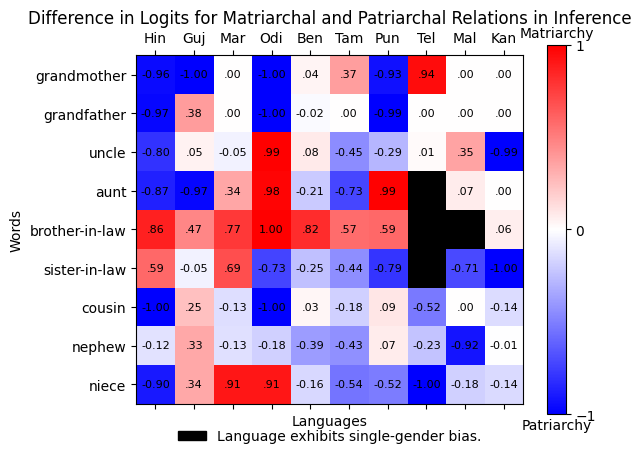

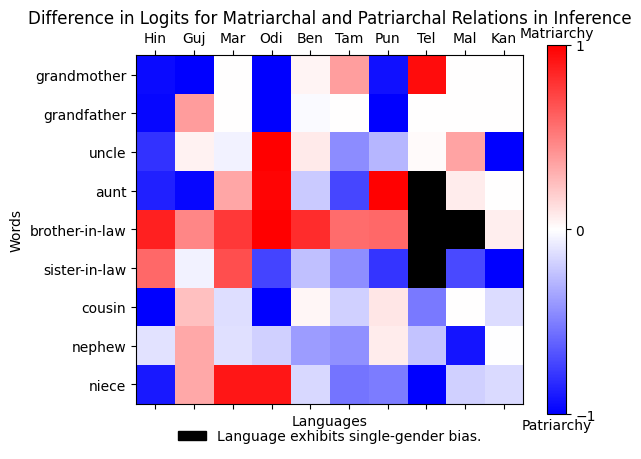

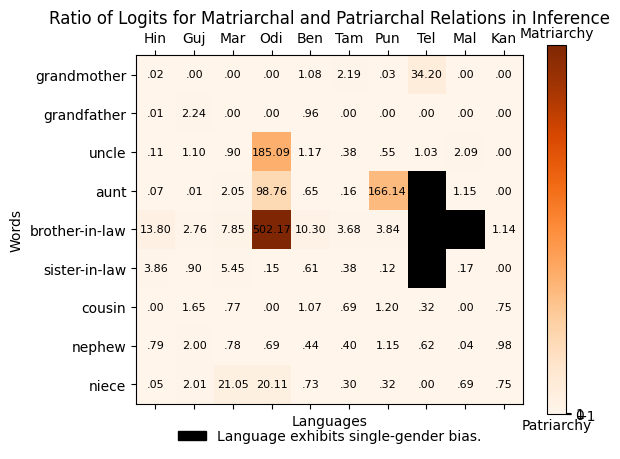

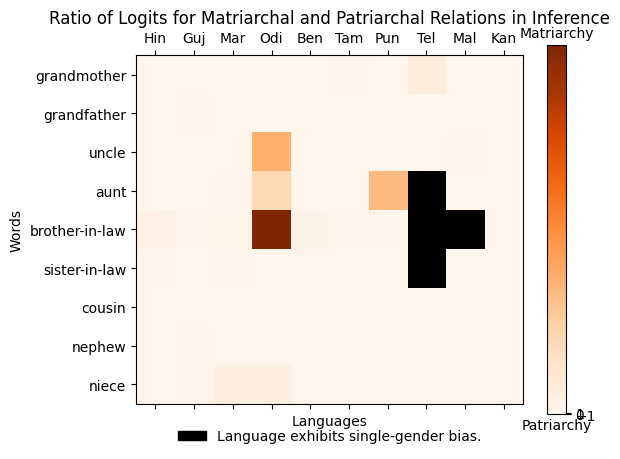

In [34]:
plot_confusion_mat(test_diff_confn_mat,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Logits for Matriarchal and Patriarchal Relations in Inference')
plot_confusion_mat(test_diff_confn_mat,  ambiguos_words, lang_code_map, annot=False, filename='logit_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Logits for Matriarchal and Patriarchal Relations in Inference')
plot_confusion_mat(confusion_mat_ratio,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')
plot_confusion_mat(confusion_mat_ratio,  ambiguos_words, lang_code_map, annot=False, filename='logit_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')

/tmp/ipykernel_159587/423080244.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ambiguos_words)


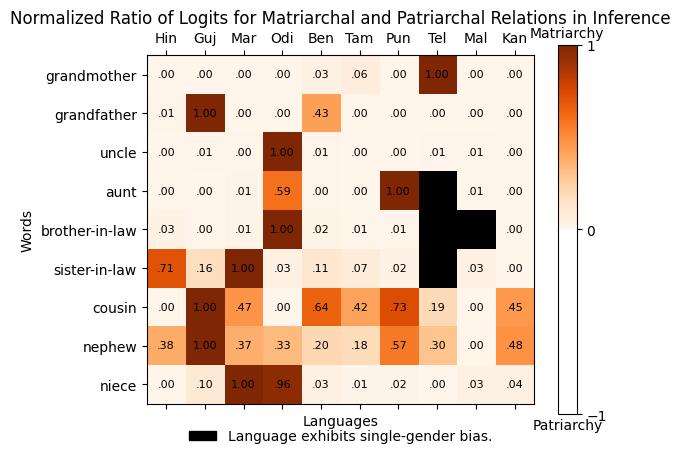

In [35]:
plot_confusion_mat(confusion_mat_ratio_normalized,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_ratio_normalized_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Normalized Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')

# Checking for Bias Amplification

In [36]:
trainset_counts={
    'tam_Taml': {'uncle': {'Matriarch': 1107, 'Patriarch': 11}, 'aunt': {'B': 207, 'Matriarch': 24}, 'grandfather': {'B': 1234}, 'grandmother': {'B': 294}, 'brother-in-law': {'Matriarch': 34}, 'nephew': {'Matriarch': 1, 'Patriarch': 4}, 'niece': {'Matriarch': 2, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 10, 'Patriarch': 13}, 'cousin': {'Matriarch': 8, 'Patriarch': 43}}
,
'mar_Deva': {'uncle': {'Matriarch': 160, 'Patriarch': 265}, 'aunt': {'Matriarch': 48, 'Patriarch': 74}, 'grandfather': {'B': 966}, 'grandmother': {'B': 392}, 'brother-in-law': {'Matriarch': 47, 'Patriarch': 10}, 'nephew': {'Matriarch': 72, 'Patriarch': 2}, 'niece': {'Matriarch': 70, 'Patriarch': 33}, 'sister-in-law': {'Matriarch': 23, 'Patriarch': 24}, 'cousin': {'Matriarch': 6, 'Patriarch': 135}}
,
'ory_Orya': {'uncle': {'Matriarch': 95, 'Patriarch': 23}, 'aunt': {'Matriarch': 9, 'Patriarch': 4}, 'grandfather': {'Matriarch': 28, 'Patriarch': 129}, 'grandmother': {'Matriarch': 6, 'Patriarch': 107}, 'brother-in-law': {'Matriarch': 7, 'Patriarch': 2}, 'nephew': {'Matriarch': 14, 'Patriarch': 32}, 'niece': {'Matriarch': 9, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 7, 'Patriarch': 17}, 'cousin': {'Patriarch': 59}}
,
'hin_Deva': {'uncle': {'Matriarch': 619, 'Patriarch': 1894}, 'aunt': {'Matriarch': 241, 'Patriarch': 380}, 'grandfather': {'Matriarch': 169, 'Patriarch': 1702}, 'grandmother': {'Matriarch': 152, 'Patriarch': 1633}, 'brother-in-law': {'Matriarch': 341, 'Patriarch': 129}, 'nephew': {'Matriarch': 53, 'Patriarch': 291}, 'niece': {'Matriarch': 218, 'Patriarch': 627}, 'sister-in-law': {'Matriarch': 87, 'Patriarch': 410}, 'cousin': {'Matriarch': 614, 'Patriarch': 1698}}
,
'kan_Knda': {'uncle': {'Matriarch': 4, 'Patriarch': 896}, 'aunt': {'B': 367}, 'grandfather': {'B': 1188}, 'grandmother': {'B': 1552}, 'brother-in-law': {'Matriarch': 67, 'Patriarch': 12}, 'nephew': {'Patriarch': 4}, 'sister-in-law': {'Patriarch': 60}, 'cousin': {'Matriarch': 23, 'Patriarch': 29}}
,
'pan_Guru': {'uncle': {'Matriarch': 22, 'Patriarch': 124}, 'aunt': {'Matriarch': 55, 'Patriarch': 19}, 'grandfather': {'Matriarch': 25, 'Patriarch': 374}, 'grandmother': {'Matriarch': 103, 'Patriarch': 294}, 'brother-in-law': {'Matriarch': 44}, 'nephew': {'Patriarch': 54}, 'niece': {'Patriarch': 75}, 'sister-in-law': {'Matriarch': 4, 'Patriarch': 11}, 'cousin': {'Matriarch': 111, 'Patriarch': 15}}
,
'tel_Telu': {'uncle': {'Matriarch': 281}, 'aunt': {'B': 9, 'Patriarch': 303}, 'grandfather': {'B': 42}, 'grandmother': {'Matriarch': 553, 'Patriarch': 2}, 'brother-in-law': {'B': 1, 'Matriarch': 39}, 'nephew': {'Matriarch': 6}, 'niece': {'Matriarch': 3, 'Patriarch': 113}, 'sister-in-law': {'Patriarch': 11}, 'cousin': {'Patriarch': 23}}
,
'mal_Mlym': {'uncle': {'B': 519, 'Matriarch': 13}, 'aunt': {'Matriarch': 9}, 'grandfather': {'B': 64}, 'grandmother': {'B': 290}, 'brother-in-law': {'B': 1, 'Matriarch': 2}, 'nephew': {'Matriarch': 27, 'Patriarch': 46}, 'niece': {'Matriarch': 12, 'Patriarch': 11}, 'sister-in-law': {'B': 2, 'Matriarch': 5}, 'cousin': {'B': 273}}
,
'guj_Gujr': {'uncle': {'Matriarch': 95, 'Patriarch': 807}, 'aunt': {'Matriarch': 43, 'Patriarch': 232}, 'grandfather': {'Matriarch': 28, 'Patriarch': 1133}, 'grandmother': {'Matriarch': 32, 'Patriarch': 1037}, 'brother-in-law': {'Matriarch': 54, 'Patriarch': 11}, 'nephew': {'Matriarch': 24, 'Patriarch': 56}, 'niece': {'Matriarch': 18, 'Patriarch': 207}, 'sister-in-law': {'Matriarch': 11, 'Patriarch': 114}, 'cousin': {'Matriarch': 28, 'Patriarch': 5}}
,
'ben_Beng': {'uncle': {'Matriarch': 163, 'Patriarch': 5}, 'grandfather': {'Matriarch': 423, 'Patriarch': 24}, 'grandmother': {'Patriarch': 14}, 'brother-in-law': {'Patriarch': 3}, 'cousin': {'Matriarch': 3, 'Patriarch': 383}}

}

In [37]:
# check if trainset_counts has the same keys as lang_script_list
# check if the values of trainset_counts are dictionaries with keys as the ambiguos words
# if not then add the key with value as empty dictionary and then add the values of the ambiguos words as 0

for lang in lang_script_list:
    if trainset_counts.get(lang, None) is None:
        print("Adding lang", lang)
        trainset_counts[lang] = {}
    for word in ambiguos_words:

        if trainset_counts[lang].get(word, None) is None:
            print("Adding word", word, "for lang", lang)
            trainset_counts[lang][word] = {}
            trainset_counts[lang][word]['Matriarch'] = 0
            trainset_counts[lang][word]['Patriarch'] = 0

Adding word aunt for lang ben_Beng
Adding word sister-in-law for lang ben_Beng
Adding word nephew for lang ben_Beng
Adding word niece for lang ben_Beng
Adding word niece for lang kan_Knda


In [38]:
trainset_counts

{'tam_Taml': {'uncle': {'Matriarch': 1107, 'Patriarch': 11},
  'aunt': {'B': 207, 'Matriarch': 24},
  'grandfather': {'B': 1234},
  'grandmother': {'B': 294},
  'brother-in-law': {'Matriarch': 34},
  'nephew': {'Matriarch': 1, 'Patriarch': 4},
  'niece': {'Matriarch': 2, 'Patriarch': 8},
  'sister-in-law': {'Matriarch': 10, 'Patriarch': 13},
  'cousin': {'Matriarch': 8, 'Patriarch': 43}},
 'mar_Deva': {'uncle': {'Matriarch': 160, 'Patriarch': 265},
  'aunt': {'Matriarch': 48, 'Patriarch': 74},
  'grandfather': {'B': 966},
  'grandmother': {'B': 392},
  'brother-in-law': {'Matriarch': 47, 'Patriarch': 10},
  'nephew': {'Matriarch': 72, 'Patriarch': 2},
  'niece': {'Matriarch': 70, 'Patriarch': 33},
  'sister-in-law': {'Matriarch': 23, 'Patriarch': 24},
  'cousin': {'Matriarch': 6, 'Patriarch': 135}},
 'ory_Orya': {'uncle': {'Matriarch': 95, 'Patriarch': 23},
  'aunt': {'Matriarch': 9, 'Patriarch': 4},
  'grandfather': {'Matriarch': 28, 'Patriarch': 129},
  'grandmother': {'Matriarch': 6

In [39]:
# for each language in lang_script_list
# for each word in ambiguos_words
# make 2 confusion matrices - train_diff_res and train_ratio_res based on softmax of patriarchy and matriarchy counts from trainset_counts

train_diff_res={}
train_ratio_res={}

for lang in lang_script_list:
    if train_diff_res.get(lang, None) is None:
        train_diff_res[lang] = {}
    if train_ratio_res.get(lang, None) is None:
        train_ratio_res[lang] = {}
    for word in ambiguos_words:
        matriarchal_count = trainset_counts[lang][word].get('Matriarch', 0)
        patriarchal_count = trainset_counts[lang][word].get('Patriarch', 0)
        neutral_count = trainset_counts[lang][word].get('B', 0)
        if matriarchal_count == 0 and patriarchal_count == 0 and neutral_count == 0: # no bias in language
            train_diff_res[lang][word] = 0
            train_ratio_res[lang][word] = 0
        elif matriarchal_count >= 0 and patriarchal_count >= 0:
            effective_counts = torch.tensor([matriarchal_count, patriarchal_count], dtype=torch.float32)
            effective_counts = softmax(effective_counts, dim=0)
            matriarchal_counts_softmax = effective_counts[0]
            patriarchal_counts_softmax = effective_counts[1]

            diff = matriarchal_counts_softmax - patriarchal_counts_softmax
            ratio = matriarchal_counts_softmax / patriarchal_counts_softmax

            train_diff_res[lang][word] = diff.item()
            train_ratio_res[lang][word] = ratio.item()
        else:
            train_diff_res[lang][word] = np.nan
            train_ratio_res[lang][word] = np.nan
            # print(f"Skipping word: {word} in lang: {lang} due to empty logits and  LANGUAGE IS BIASED.", "patriarchal" if len(matriarchal_logits) == 0 else "matriarchal")




In [40]:
train_diff_res

{'hin_Deva': {'grandmother': -1.0,
  'grandfather': -1.0,
  'uncle': -1.0,
  'aunt': -1.0,
  'brother-in-law': 1.0,
  'sister-in-law': -1.0,
  'cousin': -1.0,
  'nephew': -1.0,
  'niece': -1.0},
 'guj_Gujr': {'grandmother': -1.0,
  'grandfather': -1.0,
  'uncle': -1.0,
  'aunt': -1.0,
  'brother-in-law': 1.0,
  'sister-in-law': -1.0,
  'cousin': 1.0,
  'nephew': -1.0,
  'niece': -1.0},
 'mar_Deva': {'grandmother': 0.0,
  'grandfather': 0.0,
  'uncle': -1.0,
  'aunt': -1.0,
  'brother-in-law': 1.0,
  'sister-in-law': -0.46211716532707214,
  'cousin': -1.0,
  'nephew': 1.0,
  'niece': 1.0},
 'ory_Orya': {'grandmother': -1.0,
  'grandfather': -1.0,
  'uncle': 1.0,
  'aunt': 0.9866143465042114,
  'brother-in-law': 0.9866143465042114,
  'sister-in-law': -0.9999091625213623,
  'cousin': -1.0,
  'nephew': -1.0,
  'niece': 0.46211716532707214},
 'ben_Beng': {'grandmother': -0.9999983310699463,
  'grandfather': 1.0,
  'uncle': 1.0,
  'aunt': 0,
  'brother-in-law': -0.9051482677459717,
  'sister

In [41]:
# train_diff_res = np.array(train_diff_res, dtype=object) # Convert to NumPy array with object dtype first
# for i, lang in enumerate((lang_script_list)):
#     for j, word in enumerate((ambiguos_words)):
#         try:
#             train_diff_res[lang][word] = float(train_diff_res[lang][word])  # Try converting to float
#         except (ValueError, TypeError):  # Handle non-numerical values
#             train_diff_res[lang][word] = np.nan # Replace with actual NaN

# # train_diff_res = train_diff_res.astype(float) # Now convert the whole array to float
# train_diff_res

In [42]:
print("Train Diff res")
print(train_diff_res)

print("Train Ratio res")
print(train_ratio_res)


# make a 2D array of the train_diff_res.. not dataframe but 2D array
train_diff_confusion_mat =[[train_diff_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Train Confusion matrix")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(train_diff_confusion_mat[i][j], end="\t")
    print()

train_ratio_conf_mat =[[train_ratio_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Train Ratio Confusion matrix")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(train_ratio_conf_mat[i][j], end="\t")
    print()


Train Diff res
{'hin_Deva': {'grandmother': -1.0, 'grandfather': -1.0, 'uncle': -1.0, 'aunt': -1.0, 'brother-in-law': 1.0, 'sister-in-law': -1.0, 'cousin': -1.0, 'nephew': -1.0, 'niece': -1.0}, 'guj_Gujr': {'grandmother': -1.0, 'grandfather': -1.0, 'uncle': -1.0, 'aunt': -1.0, 'brother-in-law': 1.0, 'sister-in-law': -1.0, 'cousin': 1.0, 'nephew': -1.0, 'niece': -1.0}, 'mar_Deva': {'grandmother': 0.0, 'grandfather': 0.0, 'uncle': -1.0, 'aunt': -1.0, 'brother-in-law': 1.0, 'sister-in-law': -0.46211716532707214, 'cousin': -1.0, 'nephew': 1.0, 'niece': 1.0}, 'ory_Orya': {'grandmother': -1.0, 'grandfather': -1.0, 'uncle': 1.0, 'aunt': 0.9866143465042114, 'brother-in-law': 0.9866143465042114, 'sister-in-law': -0.9999091625213623, 'cousin': -1.0, 'nephew': -1.0, 'niece': 0.46211716532707214}, 'ben_Beng': {'grandmother': -0.9999983310699463, 'grandfather': 1.0, 'uncle': 1.0, 'aunt': 0, 'brother-in-law': -0.9051482677459717, 'sister-in-law': 0, 'cousin': -1.0, 'nephew': 0, 'niece': 0}, 'tam_Tam

/tmp/ipykernel_159587/423080244.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ambiguos_words)


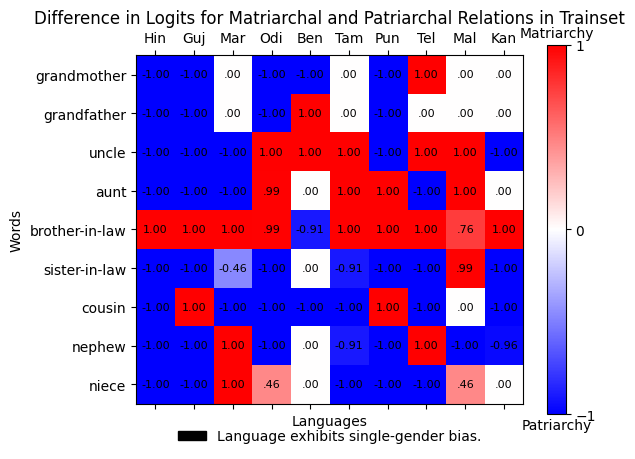

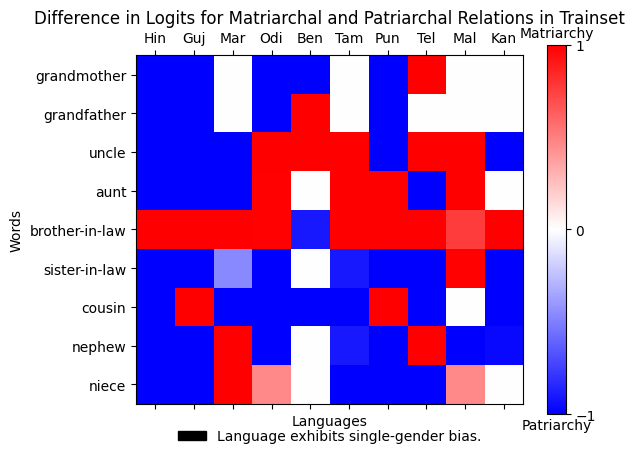

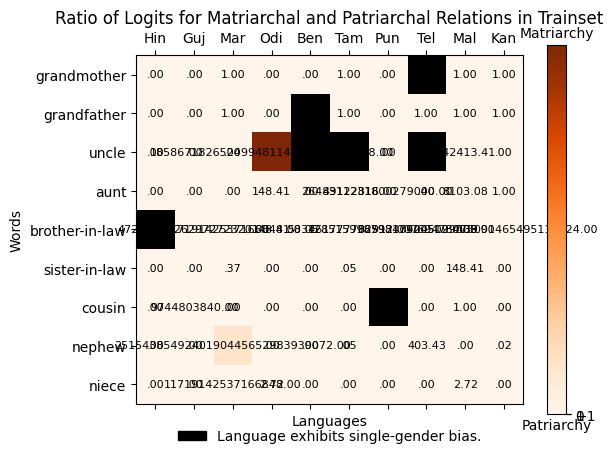

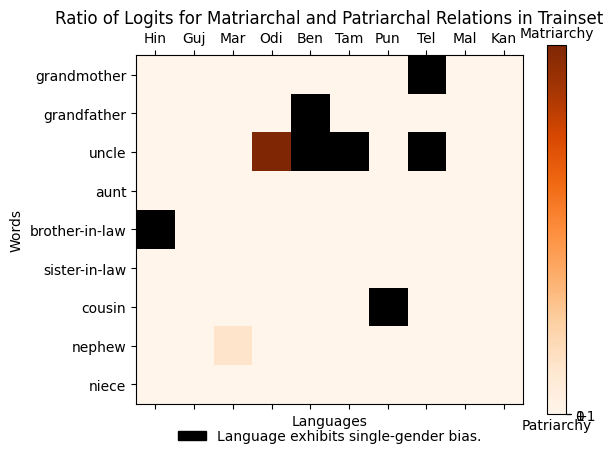

In [43]:
plot_confusion_mat(train_diff_confusion_mat,  ambiguos_words, lang_code_map, annot=True, filename='trainset_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Logits for Matriarchal and Patriarchal Relations in Trainset')
plot_confusion_mat(train_diff_confusion_mat,  ambiguos_words, lang_code_map, annot=False, filename='trainset_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Logits for Matriarchal and Patriarchal Relations in Trainset')
plot_confusion_mat(train_ratio_conf_mat,  ambiguos_words, lang_code_map, annot=True, filename='trainset_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Trainset')
plot_confusion_mat(train_ratio_conf_mat,  ambiguos_words, lang_code_map, annot=False, filename='trainset_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Trainset')

## Is BIAS Amplified?

In [44]:
result_ratio = np.array(test_diff_confn_mat) /  np.array(train_diff_confusion_mat)

result_diff = np.array(confusion_mat_ratio) /  np.array(train_ratio_conf_mat) 

result_diff_norm = np.array(confusion_mat_ratio_normalized) /  np.array(train_ratio_conf_mat)

/tmp/ipykernel_159587/2771232322.py:1: RuntimeWarning: divide by zero encountered in divide
  result_ratio = np.array(test_diff_confn_mat) /  np.array(train_diff_confusion_mat)
/tmp/ipykernel_159587/2771232322.py:1: RuntimeWarning: invalid value encountered in divide
  result_ratio = np.array(test_diff_confn_mat) /  np.array(train_diff_confusion_mat)
/tmp/ipykernel_159587/2771232322.py:3: RuntimeWarning: divide by zero encountered in divide
  result_diff = np.array(confusion_mat_ratio) /  np.array(train_ratio_conf_mat)
/tmp/ipykernel_159587/2771232322.py:5: RuntimeWarning: divide by zero encountered in divide
  result_diff_norm = np.array(confusion_mat_ratio_normalized) /  np.array(train_ratio_conf_mat)
/tmp/ipykernel_159587/2771232322.py:5: RuntimeWarning: invalid value encountered in divide
  result_diff_norm = np.array(confusion_mat_ratio_normalized) /  np.array(train_ratio_conf_mat)


In [45]:


print("Result Ratio")
print("words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(result_ratio[i][j], end="\t")
    print()

print("Result Diff")
print("words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(result_diff[i][j], end="\t")
    print()

print("Result Diff Normalized")
print("words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(result_diff_norm[i][j], end="\t")
    print()

Result Ratio
words	hin_Deva	guj_Gujr	mar_Deva	ory_Orya	ben_Beng	tam_Taml	pan_Guru	tel_Telu	mal_Mlym	kan_Knda	grandmother	0.9563671946525574	0.9959551692008972	nan	0.9997027516365051	-0.03829715086938288	inf	0.9341439008712769	0.943178653717041	nan	nan	
grandfather	0.9727887511253357	-0.38336774706840515	nan	0.9990313053131104	-0.02056330442428589	nan	0.9929695725440979	nan	nan	nan	
uncle	0.8003621101379395	-0.04723989963531494	0.05213668942451477	0.9892522692680359	0.07669368386268616	-0.4483254551887512	0.28975793719291687	0.013987064361572266	0.35211287501922256	0.993064284324646	
aunt	0.8688442707061768	0.970579981803894	-0.34336230158805847	0.9932474827885482	-inf	-0.7263556718826294	0.9880340099334717	nan	0.07173871983886557	nan	
brother-in-law	0.8648267388343811	0.46762534976005554	0.7739558219909668	1.009538598128323	-0.9091985390627655	0.572455883026123	0.5871224403381348	nan	nan	0.06499302387237549	
sister-in-law	-0.5882759094238281	0.05484640598297119	-1.4930589480422485	0.73

In [46]:


# write to file named "logits_confusion_matrix.txt", title:"RESULTS----" 
# put heading as the languages used. next line all ambiguos words, next lines the Results

with open('../logits_confusion_matrix.txt', 'a') as f:
    f.write("---RESULTS----")
    f.write("Results ratio")
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in result_ratio:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')
    f.write('\n\n')

    f.write("Difference result matrix")
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in result_diff:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')

    f.write('\n\n')

    f.write("Normalized Difference result matrix")
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in result_diff_norm:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')



    f.close()


In [47]:
# plot the confusion matrix of the result_ratio and result_diff and normalized result_diff

plot_confusion_mat(result_ratio, result_ratio, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Ratio of Difference in Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff, result_diff, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_norm, result_diff_norm, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_diff_norm_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Normalized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_norm, result_diff_norm, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_diff_norm_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Normalized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')

plot_confusion_mat(result_ratio, result_ratio, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_res_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Ratio of Difference in Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff, result_diff, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_res_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')

TypeError: plot_confusion_mat() got multiple values for argument 'annot'

## Normalized Values:

In [ ]:
# resplace result_ratio

array([[ 0.77659577,  0.98708552,         nan,  0.99971002,         nan,
                nan,        -inf,         inf,         nan,         nan],
       [ 0.98355079,  0.99931085,         nan,  0.99842292,  0.89326572,
                nan,        -inf,         nan,         nan,         nan],
       [ 0.91440934,  0.98478514,  0.96705377,  0.97183859, -0.26269287,
         0.99987102,        -inf,         inf,         nan,  0.9925952 ],
       [ 0.94611704,  0.98714638, -0.85648543,  1.00125176,        -inf,
                nan,         inf,         nan,         nan,         nan],
       [ 0.58025467,  0.99997044,  0.99989873,  1.01121338,         nan,
                nan,         inf,         nan,         nan,  0.91696787],
       [-0.81078708, -0.13775218, -0.99363417,  0.43975432,        -inf,
         0.55469177,        -inf,         nan,         nan,         nan],
       [ 0.99672008,  0.06222993,  0.97947735,         nan,  0.9226684 ,
         0.3049314 ,        -inf,        -inf

/tmp/ipykernel_1131734/3762853840.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ambiguos_words)


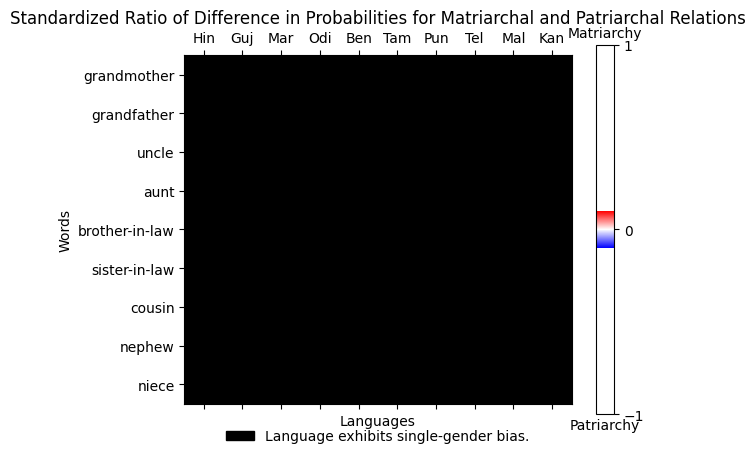

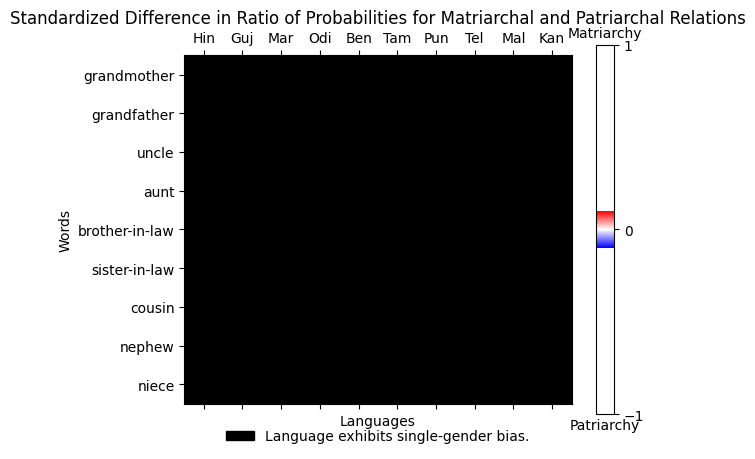

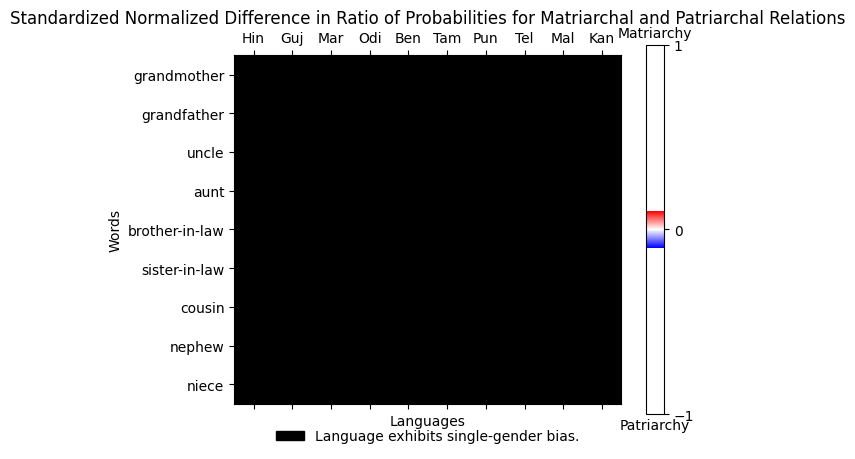

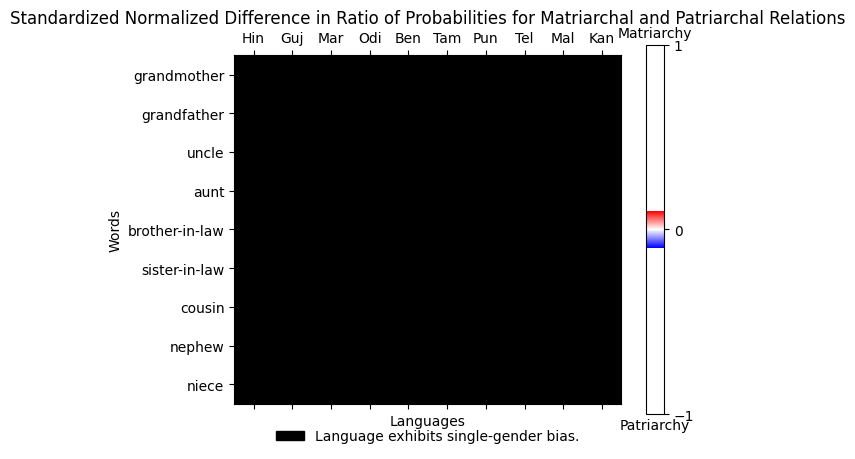

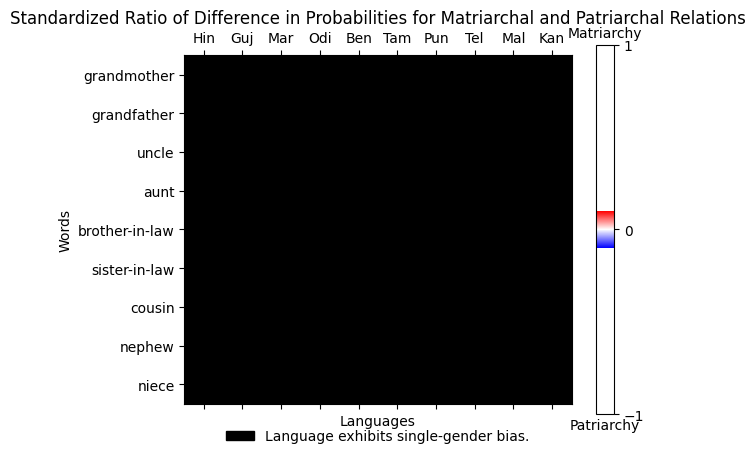

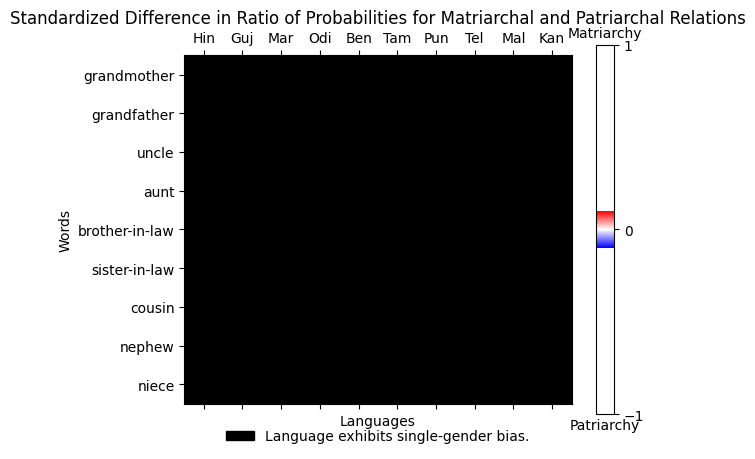

In [ ]:
# Standardize result_ratio and result_diff and normalized result_diff between values 0 to 1 if not negative values else -1 to 1

result_ratio_std = (result_ratio - np.min(result_ratio)) / (np.max(result_ratio) - np.min(result_ratio))
result_diff_std = (result_diff - np.min(result_diff)) / (np.max(result_diff) - np.min(result_diff))
result_diff_norm_std = (result_diff_norm - np.min(result_diff_norm)) / (np.max(result_diff_norm) - np.min(result_diff_norm))

plot_confusion_mat(result_ratio_std, result_ratio_std, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_ratio_std_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Standardized Ratio of Difference in Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_std, result_diff_std, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_diff_std_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Standardized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_norm_std, result_diff_norm_std, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_diff_norm_std_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Standardized Normalized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_norm_std, result_diff_norm_std, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_diff_norm_std_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Standardized Normalized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')

plot_confusion_mat(result_ratio_std, result_ratio_std, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_res_ratio_std_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Standardized Ratio of Difference in Probabilities for Matriarchal and Patriarchal Relations')    
plot_confusion_mat(result_diff_std, result_diff_std, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_res_diff_std_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Standardized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')

In [ ]:
plot_confusion_mat(result_ratio, result_ratio, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Ratio of Difference in Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff, result_diff, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_norm, result_diff_norm, ambiguos_words, lang_code_map, annot=True, filename='logit_prob_res_diff_norm_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Normalized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff_norm, result_diff_norm, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_diff_norm_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Normalized Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')

plot_confusion_mat(result_ratio, result_ratio, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_res_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Ratio of Difference in Probabilities for Matriarchal and Patriarchal Relations')
plot_confusion_mat(result_diff, result_diff, ambiguos_words, lang_code_map, annot=False, filename='logit_prob_res_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Difference in Ratio of Probabilities for Matriarchal and Patriarchal Relations')

In [ ]:
# index of ['ମାମୁଁ', 'ମଉସା'] in vocab of en_indic_tokenizer
# print(en_indic_tokenizer.convert_tokens_to_ids(['ମାମୁଁ', 'ମଉସା'])) #[3, 3] - wrong

# print(en_indic_tokenizer.vocab



In [ ]:
# # import the test_sentences_eng.txt file data as sents

# # sents = ['The river is blue.', 'My uncle wearing blue coat.', 'My maternal aunt went to the river bank.', "The doctor went to bank for money."]
# sents=['My maternal aunt went to the river bank.', 'My maternal aunt loves me.', 
#        'My maternal aunt loves her grandchildren.', "My maternal aunt loves her children.", 
#        "My maternal aunt loves her family.",
#        ]   
# src_lang = "eng_Latn"

# tgt_lang = 'hin_Deva'
# # print(lang)
# translations, logits = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind)


In [ ]:
# print(translations)

In [ ]:
# print(logits)

##### Verify for Odia that logits at correct positions have been extracted

In [ ]:
# for each logit in logits, convert it to prob using softmax
for lang in lang_script_list:
    if lang != 'ory_Orya':
        continue
    logits = output_logits[lang]
    softmax_logits = [softmax(logit, dim=-1) for logit in logits]
    print(softmax_logits)
    print(len(softmax_logits) ) # for each sentence translated)
    print(softmax_logits[0].shape) # for each word in the sentence; vocab size

# for each sentence, amongs all vocab logits, find the difference of [sum of matrirach words] - [sum of patriarch words]
# find the root word in english and as per lang, find the other Matriarch or Patriarch words based on relation code 

[tensor([3.7110e-07, 3.7125e-07, 8.8791e-08,  ..., 3.7129e-07, 3.7124e-07,
        3.7119e-07]), tensor([4.0578e-07, 4.0592e-07, 1.2152e-07,  ..., 4.0595e-07, 4.0592e-07,
        4.0590e-07]), tensor([9.2830e-07, 9.2852e-07, 6.7482e-07,  ..., 9.2844e-07, 9.2845e-07,
        9.2833e-07]), tensor([1.0123e-06, 1.0126e-06, 4.2847e-07,  ..., 1.0127e-06, 1.0125e-06,
        1.0124e-06]), tensor([5.1026e-07, 5.1033e-07, 9.6359e-08,  ..., 5.1031e-07, 5.1047e-07,
        5.1035e-07]), tensor([7.0415e-07, 7.0428e-07, 2.1526e-07,  ..., 7.0433e-07, 7.0440e-07,
        7.0428e-07]), tensor([2.7632e-07, 2.7635e-07, 2.4907e-07,  ..., 2.7631e-07, 2.7640e-07,
        2.7632e-07]), tensor([3.6774e-07, 3.6776e-07, 1.5722e-07,  ..., 3.6778e-07, 3.6784e-07,
        3.6775e-07]), tensor([9.8169e-07, 9.8176e-07, 2.1989e-07,  ..., 9.8176e-07, 9.8193e-07,
        9.8180e-07]), tensor([3.4872e-07, 3.4889e-07, 8.5611e-08,  ..., 3.4893e-07, 3.4886e-07,
        3.4881e-07]), tensor([3.8986e-07, 3.9000e-07, 1.1741e

In [ ]:
# get the index of max prob for each logit
max_prob_index = [torch.argmax(softmax_logit, dim=-1) for softmax_logit in softmax_logits]
print(max_prob_index)

[tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(2), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(2), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(3991), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(2), tensor(3991), tensor(4300

In [ ]:
# from the softmax_logits, get the indices of top 10 max prob 
top_10_indices = [torch.topk(softmax_logit, k=10, dim=-1) for softmax_logit in softmax_logits]
print(top_10_indices)

[torch.return_types.topk(
values=tensor([0.8819, 0.0048, 0.0035, 0.0031, 0.0028, 0.0021, 0.0021, 0.0016, 0.0016,
        0.0014]),
indices=tensor([41445,    80,    30,  8911, 51174, 33622, 29498, 48446, 30261, 30502])), torch.return_types.topk(
values=tensor([0.8307, 0.0312, 0.0204, 0.0101, 0.0086, 0.0077, 0.0056, 0.0023, 0.0017,
        0.0010]),
indices=tensor([41445, 53208, 15588, 20077, 30502,    30,   409,  1111, 55513, 51174])), torch.return_types.topk(
values=tensor([0.5095, 0.1921, 0.0316, 0.0116, 0.0104, 0.0051, 0.0042, 0.0039, 0.0035,
        0.0034]),
indices=tensor([ 9971, 41565, 24501,    30, 41445,  7610, 20077,  3991,  3617, 15588])), torch.return_types.topk(
values=tensor([0.6049, 0.0271, 0.0156, 0.0094, 0.0076, 0.0057, 0.0053, 0.0051, 0.0051,
        0.0049]),
indices=tensor([30261, 41445,  9971,    30,  3617,   213, 54203,   336, 58401,  1390])), torch.return_types.topk(
values=tensor([0.6247, 0.0746, 0.0439, 0.0279, 0.0132, 0.0132, 0.0124, 0.0089, 0.0055,
        0.0

In [ ]:
# from the top_10_indices, get the words in Hindi vocab using tokenizer.target_tokenizer
word_list = []
for i in top_10_indices:
    with en_indic_tokenizer.as_target_tokenizer():
        word_list.append(en_indic_tokenizer.batch_decode(i.indices))
print(word_list)

/home/sofia/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[['जेजे ', 'न ', "' ", 'नानी ', 'नाति ', 'माआ ', 'दादी ', 'दिदि ', 'माउ ', 'पिताम '], ['जेजे ', 'पितामह ', 'दादा ', 'बापा ', 'पिताम ', "' ", 'द ', 'बड़ ', 'बापाङ्क ', 'नाति '], ['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'बापा ', 'भाइ ', 'खु ', 'दादा '], ['माउ ', 'जेजे ', 'माम ', "' ", 'खु ', 'अ ', 'माङ्क ', 'ब ', 'कुनि ', 'बो '], ['भि ', 'श् ', 'भा ', 'ज् ', 'श ', 'भ ', 'बो ', 'सा ', 'भाइ ', 'भाइर '], ['भा ', 'भि ', 'श् ', 'बो ', 'भउणी ', 'झ ', 'ज् ', 'श ', 'भ ', 'शा '], ['भाइ ', 'जणे ', 'भउणी ', 'भाइ ', 'जणक ', 'बो ', '- ', 'बन्धु ', 'पुअ ', 'सम्पर्कीय़ '], ['पुत ', 'भण ', 'भ ', 'भाइ ', "' ", 'पु ', 'भ्र ', 'भा ', 'सान ', 'सम्पर्कीय़ '], ['भ ', 'भण ', 'पुत ', 'झ ', 'भा ', 'भउणी ', 'भग ', 'भाइ ', 'बो ', 'जणे '], ['जेजे ', 'न ', 'नानी ', "' ", 'दादी ', 'नाति ', 'दिदि ', 'माआ ', 'आइ ', 'मात '], ['जेजे ', 'पितामह ', 'दादा ', 'पिताम ', 'बापा ', 'द ', "' ", 'बड़ ', 'बापाङ्क ', 'दाद '], ['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'चाचा ', 'बापा ', 'दादा ', 'खु '], ['माउ ', 'जेजे

In [ ]:
for _ in word_list:
    print(_)

['जेजे ', 'न ', "' ", 'नानी ', 'नाति ', 'माआ ', 'दादी ', 'दिदि ', 'माउ ', 'पिताम ']
['जेजे ', 'पितामह ', 'दादा ', 'बापा ', 'पिताम ', "' ", 'द ', 'बड़ ', 'बापाङ्क ', 'नाति ']
['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'बापा ', 'भाइ ', 'खु ', 'दादा ']
['माउ ', 'जेजे ', 'माम ', "' ", 'खु ', 'अ ', 'माङ्क ', 'ब ', 'कुनि ', 'बो ']
['भि ', 'श् ', 'भा ', 'ज् ', 'श ', 'भ ', 'बो ', 'सा ', 'भाइ ', 'भाइर ']
['भा ', 'भि ', 'श् ', 'बो ', 'भउणी ', 'झ ', 'ज् ', 'श ', 'भ ', 'शा ']
['भाइ ', 'जणे ', 'भउणी ', 'भाइ ', 'जणक ', 'बो ', '- ', 'बन्धु ', 'पुअ ', 'सम्पर्कीय़ ']
['पुत ', 'भण ', 'भ ', 'भाइ ', "' ", 'पु ', 'भ्र ', 'भा ', 'सान ', 'सम्पर्कीय़ ']
['भ ', 'भण ', 'पुत ', 'झ ', 'भा ', 'भउणी ', 'भग ', 'भाइ ', 'बो ', 'जणे ']
['जेजे ', 'न ', 'नानी ', "' ", 'दादी ', 'नाति ', 'दिदि ', 'माआ ', 'आइ ', 'मात ']
['जेजे ', 'पितामह ', 'दादा ', 'पिताम ', 'बापा ', 'द ', "' ", 'बड़ ', 'बापाङ्क ', 'दाद ']
['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'चाचा ', 'बापा ', 'दादा ', 'खु ']
['माउ ', 'जेजे ', 'माम ', "

## Getting the pearson correlation
Pearson Correlation between confusion_mat and that of the original datasetby using library scipy.stats.pearsonr

In [ ]:
test_diff_confn_mat

[[-0.7765957713127136,
  -0.9870855212211609,
  0,
  -0.9997100234031677,
  -0.015027940273284912,
  -0.009209960699081421,
  -0.7288663387298584,
  0.9158009886741638,
  0,
  0],
 [-0.9835507869720459,
  -0.9993108510971069,
  0,
  -0.9984229207038879,
  0.8932657241821289,
  0,
  -0.9955326914787292,
  0,
  0,
  0],
 [-0.914409339427948,
  -0.9847851395606995,
  -0.9670537710189819,
  0.9718385934829712,
  -0.2626928687095642,
  0.999871015548706,
  -0.9180032014846802,
  0.24358052015304565,
  0.17130237817764282,
  -0.9925951957702637],
 [-0.9461170434951782,
  -0.9871463775634766,
  0.8564854264259338,
  0.9878493547439575,
  -0.19272536039352417,
  0.5309692621231079,
  0.9941092133522034,
  nan,
  -0.05859598517417908,
  0],
 [0.5802546739578247,
  0.9999704360961914,
  0.9998987317085266,
  0.9976776242256165,
  0.7899119853973389,
  0.9999794960021973,
  0.9786496758460999,
  nan,
  nan,
  0.9169678688049316],
 [0.8107870817184448,
  0.13775217533111572,
  0.4591754078865051,


# CONCLUSION

Found logits for ambiguos english words just before translating